In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import pingouin as pg

## Generate Simulated Correlation Matrices

We decided to first test the GNN on simulated data. To do this, we need to generate data with simple relations between variables that would clearly show on a correlation matrix.

We start off by generating a n x m dataframe, where n is the number of time points and m is the number of regions in our simplified model of the brain. Each cell in this dataframe is filled with random noise. The greater the number of time points n, the less noise will appear in the correlation matrix.

Then, each row of the dataframe has a low chance of being multiplied by a 1 x m vector, which is preset beforehand. This vector contains weights for each of the m regions and can be set to force regions to correlate with each other. For example, if regions  A and B have weights of 2 while the other regions have a weight of 1, then regions A and B will be positively correlated.

The chance for this multiplication to occur should not be too high or too low. If it is too low, then it will not occur if n is also low. If the chance is too high, then most of the rows will be multiplied and the increase/decrease instead becomes an inherent feature of the brain region.

In [2]:
def mult_chance(row,mult_lst,chance):
    if np.random.random() < chance:
        return row * mult_lst
    return row

def gen_data(mult_lst,num_rows,num_features = 10): # old method. see gen_data_revised
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.5), axis=1)
    return df

kwarg_dict = {'vmin':-1, 'vmax':1,'center':0}
fisher_dict = {'vmin':-3, 'vmax':3,'center':0}

# generates plots for pearson, partial, pearson w/ fisher, 
# partial w/ fisher correlation matrices
def plot_corr_pcorr(data):
    fig, ax = plt.subplots(2,2,figsize=(11,9))
    
    corr = data.corr()
    pcorr = data.pcorr()
    fcorr = apply_fisher(corr)
    fpcorr = apply_fisher(pcorr)
    
    sns.heatmap(corr, ax=ax[0][0],**kwarg_dict)
    ax[0][0].set_title("Pearson Correlation")
    sns.heatmap(pcorr, ax=ax[0][1],**kwarg_dict)
    ax[0][1].set_title("Partial Correlation")
    
    sns.heatmap(fcorr, ax=ax[1][0],**fisher_dict)
    ax[1][0].set_title("Pearson Correlation w/ Fisher Transform")
    sns.heatmap(fpcorr, ax=ax[1][1],**fisher_dict)
    ax[1][1].set_title("Partial Correlation w/ Fisher Transform")
    
    plt.show()
    print("Pearson Positive Definite: ", positive_definite(corr))
    print("Partial Positive Definite: ", positive_definite(pcorr))
    print("Pearson w/ Fisher Transform Positive Definite: ", positive_definite(fcorr))
    print("Partial w/ Fisher Transform Positive Definite: ", positive_definite(fpcorr))

def positive_definite(data):
    # positive definite when all eigenvalues are greater than 0
    return np.all(np.linalg.eigvals(data) > 0)

def apply_fisher(data):
    numpied = data.to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.arctanh(numpied)

In [3]:
def pcorr_test(X_corr):
    X_inv = np.linalg.inv(X_corr)
    X_pcorr = -X_inv / np.outer(np.sqrt(np.diag(X_inv)), np.sqrt(np.diag(X_inv)))
    return X_pcorr

Here we have a simulated brain with 10 regions. Let us assume that in the male brain, regions 0 to 4 are correlated with each other. We can force this correlation by increasing the weights of the male_lst in regions 0 to 4 while leaving the other weights as 1.

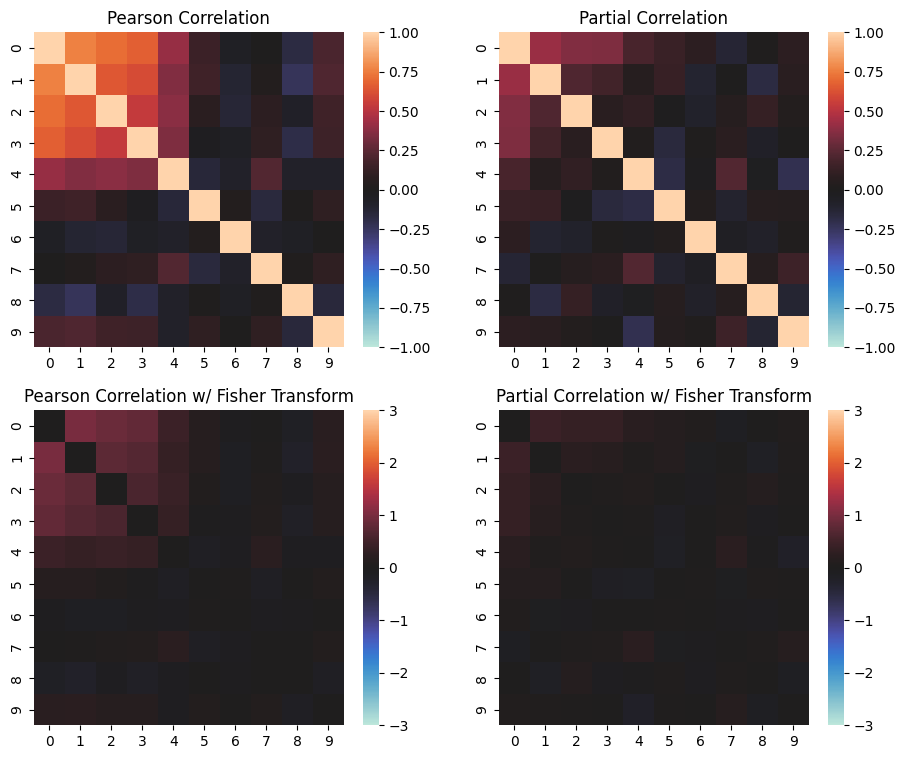

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [4]:
male_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        1,
        1,
        1,
        1,
        1
    ]

df = gen_data(male_lst,100)
plot_corr_pcorr(df)

Let's also assume that in the female brain, regions 5 to 9 are correlated with each other.

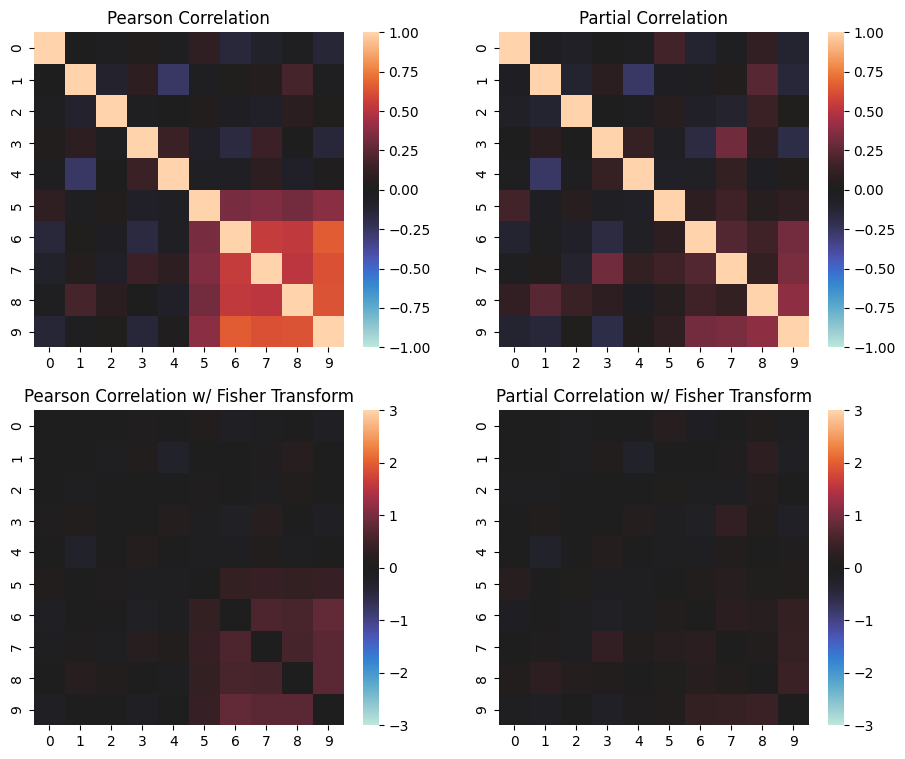

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [5]:
female_lst = [
        1,
        1,
        1,
        1,
        1,
        1.2,
        1.4,
        1.6,
        1.8,
        2
    ]

df = gen_data(female_lst,100)
plot_corr_pcorr(df)

From the heatmaps above, we can see that the regions of the simulated brains that are correlated with each other are lit up, while the regions that are not correlated stay dark. The small amount of noise in the matrices can be removed by using a larger number of time points when generating the dataframe.

However, there is an issue with the partial correlation matrix. While the pearson correlation shows the correlation between multiple regions, the partial correlation excludes other regions when considering the relationship between two regions.

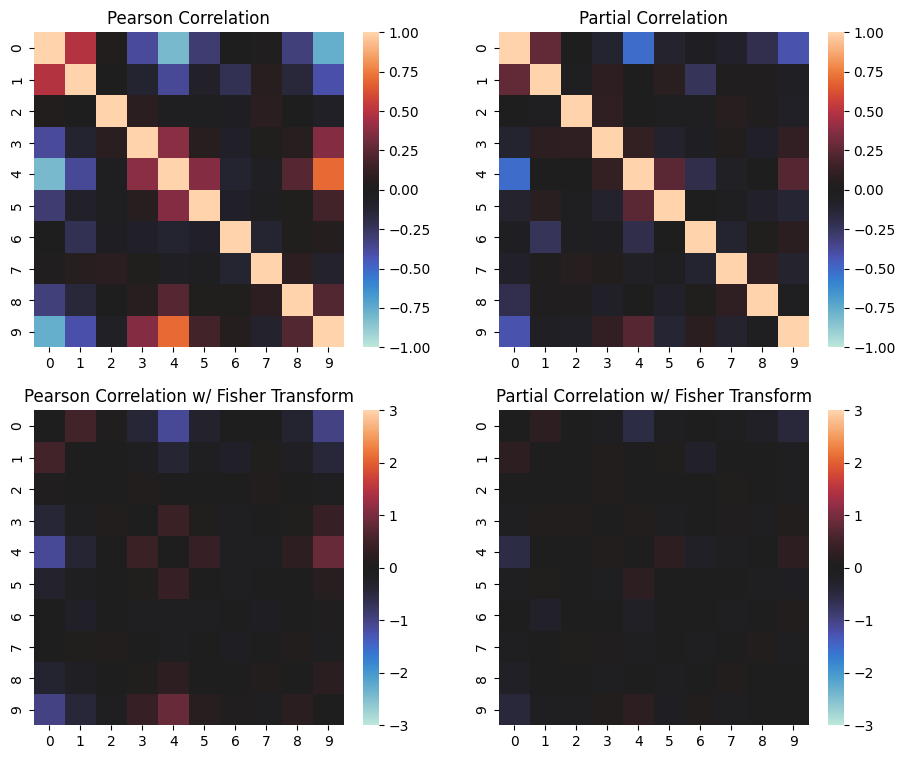

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [6]:
some_lst = [0.4,0.8,1,1.2,2,1.2,1,1,1.2,2] # arbitrary

df = gen_data(some_lst,100)
plot_corr_pcorr(df)

In the heatmap above, the correlations are clearly shown on the pearson correlation but are very mute on the partial correlation. This means that the current method of multiplying the rows by only one vector will not work well in generating partial correlations.

In [7]:
def gen_data2(lst1,num_rows): # also old method. see gen_data_revised
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, 10)))
    
    for lst2 in lst1:
        df = df.apply(lambda x: mult_chance(x,lst2,0.2), axis=1)    
    return df

This is an updated version of the data generation function. Instead of multiplying by one vector, each row of the data has a chance to be multiplied by multiple different vectors. This way, we can model more complex relationships in the correlation matrix.

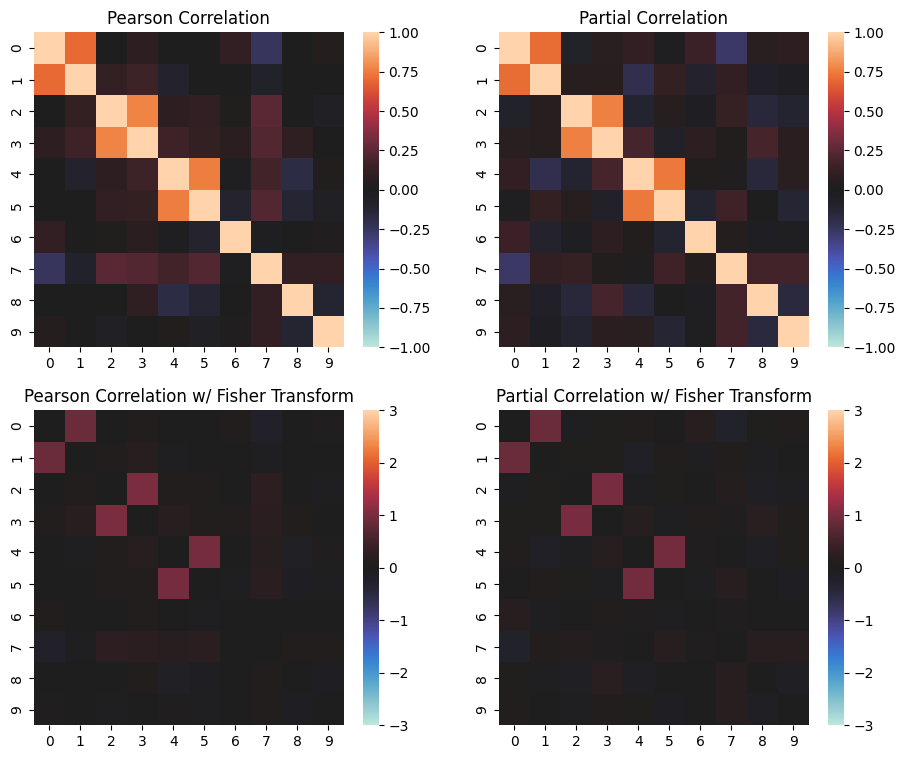

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [8]:
tuple_lst = [
    [2,2,1,1,1,1,1,1,1,1], # region 0 with region 1
    [1,1,2,2,1,1,1,1,1,1], # region 2 with region 3
    [1,1,1,1,2,2,1,1,1,1] # region 4 with region 5
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

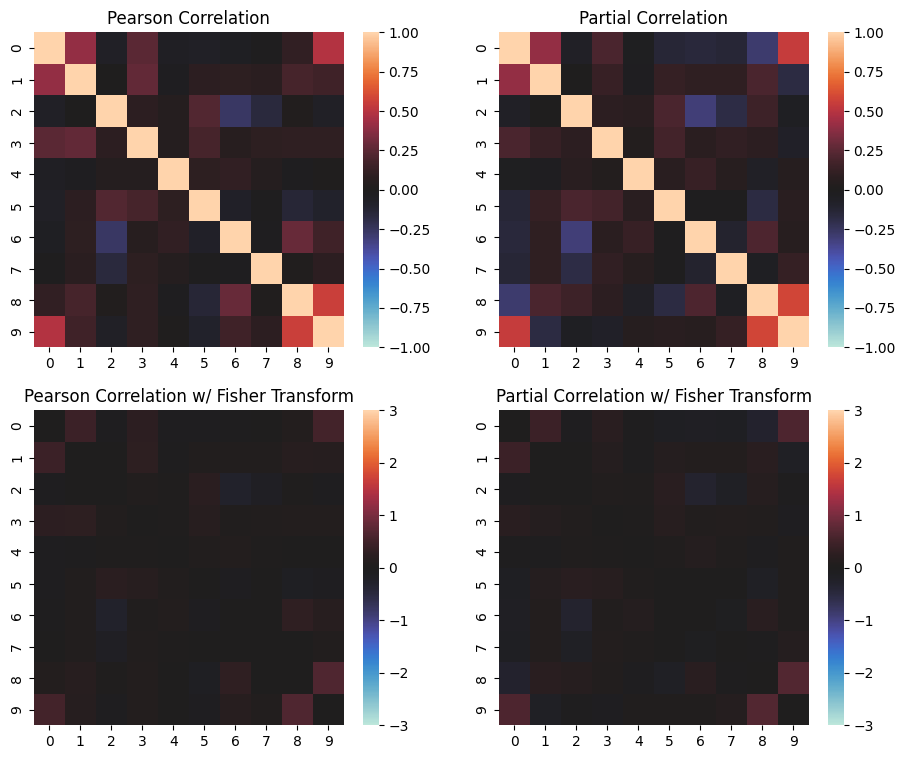

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [9]:
tuple_lst = [
    [2,1.6,1,1.1,1,1,1,1,1,1], # regions 0 and 1
    [1,1,1,1,1,1,1.1,1,1.6,2], # regions 8 and 9
    [2,1,1,1,1,1,1,1,1,2], # region 0 with region 9
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

With this method, using vectors that only affect two regions is the most effective. Once the vector modifies three or more regions, the partial correlation calculations will exclude the regions and obscure them from the heatmap.

## What we will be using

The list below contains generated correlation matrices for 100 subjects. Index 0 has 'M' for male and 'F' for female. Index 1 and 2 are the pearson and partial correlation matrices.

As shown in the above heatmaps, while all of the pearson correlation matrices are positive definite, there are some partial correlation matrices that are not. These will be filtered out before the subjects are added.

In [10]:
simulated_subjects = []

while len(simulated_subjects) < 500:
    df = gen_data(male_lst,100)
    c = df.corr()
    p = df.pcorr()
    fc = apply_fisher(c)
    fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('M',df,c,p,fc,fpc)]
while len(simulated_subjects) < 1000:
    df = gen_data(female_lst,100)
    c = df.corr()
    p = df.pcorr()
    fc = apply_fisher(c)
    fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('F',df,c,p,fc,fpc)]
random.shuffle(simulated_subjects)

In [11]:
# check for any non positive definite
for i in simulated_subjects:
    c = i[2]
    p = i[3]
    if (not positive_definite(c)):
        print(1)
    if (not positive_definite(p)):
        print(2)

Gender: F


Text(0.5, 1.0, 'Partial Correlation w/ Fisher Transform')

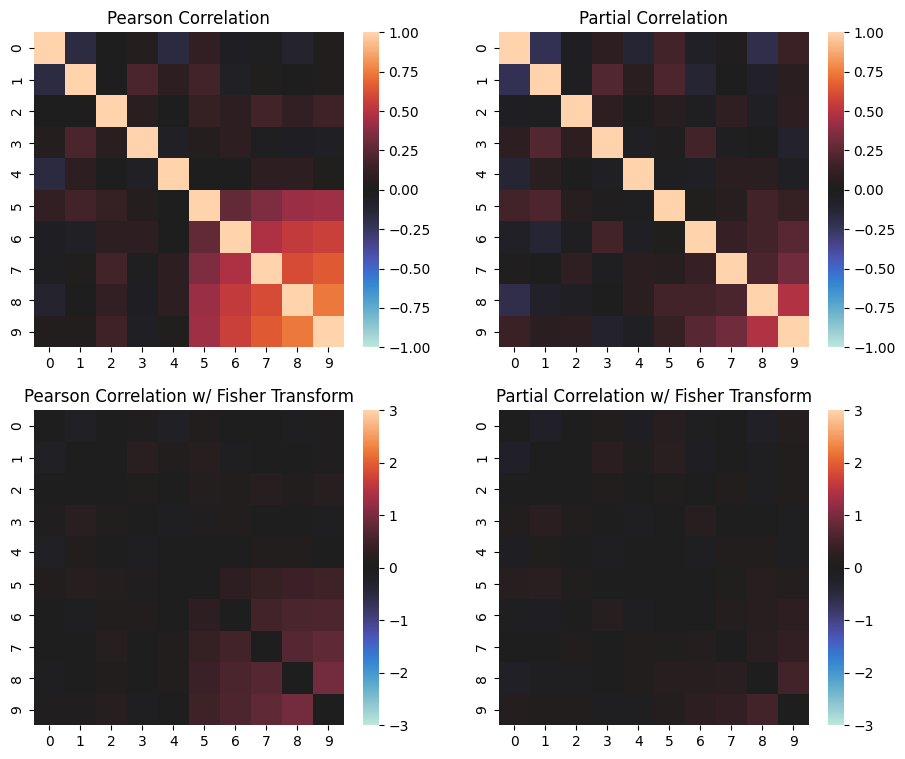

In [12]:
# take a look at the first subject in the list
subject0 = simulated_subjects[0]
gender0 = subject0[0] # this is gender
data0 = subject0[1] # this is the dataset that generated the correlation matrices
corr0 = subject0[2] # this is the pearson correlation
pcorr0 = subject0[3] # this is the partial correlation
fcorr0 = subject0[4] # this is the fisher transformed pearson correlation
fpcorr0 = subject0[5] # this is the fisher transformed partial correlation

print("Gender:",gender0)
fig, ax = plt.subplots(2,2,figsize=(11,9))
sns.heatmap(corr0, ax=ax[0][0],**kwarg_dict)
ax[0][0].set_title("Pearson Correlation")
sns.heatmap(pcorr0, ax=ax[0][1],**kwarg_dict)
ax[0][1].set_title("Partial Correlation")

sns.heatmap(fcorr0, ax=ax[1][0],**fisher_dict)
ax[1][0].set_title("Pearson Correlation w/ Fisher Transform")
sns.heatmap(fpcorr0, ax=ax[1][1],**fisher_dict)
ax[1][1].set_title("Partial Correlation w/ Fisher Transform")

We also need an ideal brain for both male and female, where there is little to no noise in the correlation matrices. We can generate this by using a long time series to approximate the ideal.

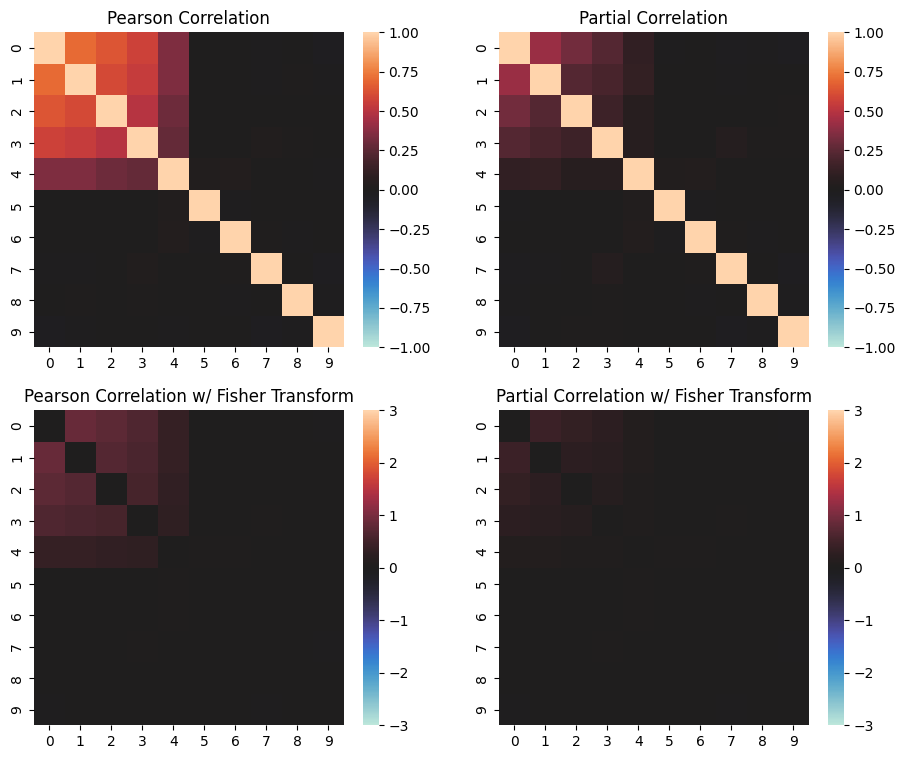

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [13]:
male_ideal_df = gen_data(male_lst,5000)
plot_corr_pcorr(male_ideal_df)

c = male_ideal_df.corr()
p = male_ideal_df.pcorr()
fc = apply_fisher(c)
fpc = apply_fisher(p)

male_ideal = ('M',male_ideal_df,c,p,fc,fpc) # use this

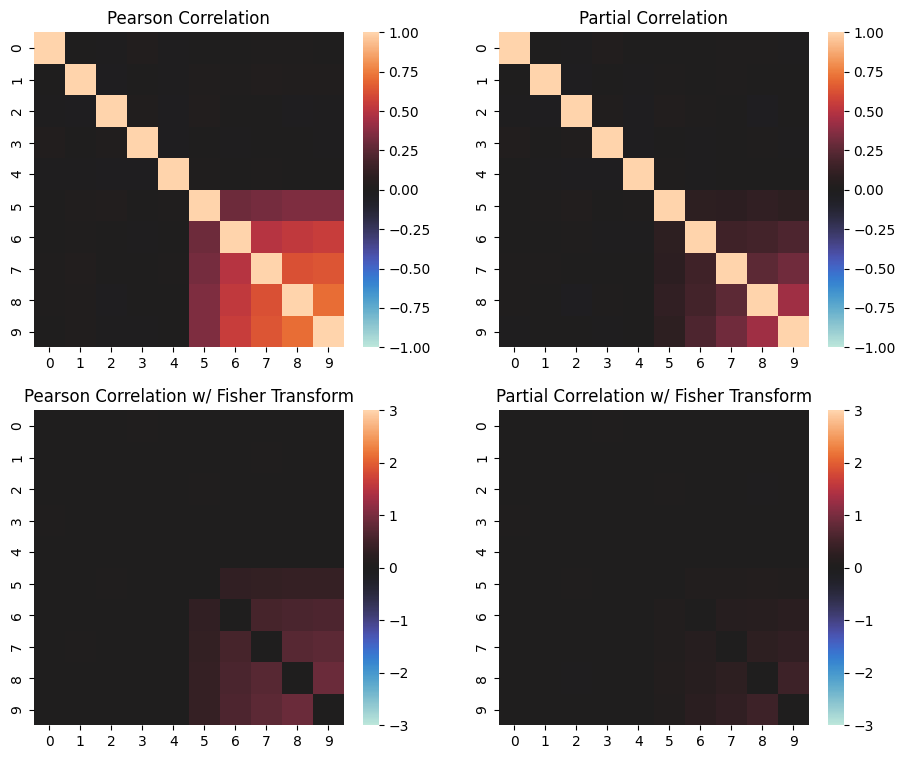

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [14]:
female_ideal_df = gen_data(female_lst,5000)
plot_corr_pcorr(female_ideal_df)

c = female_ideal_df.corr()
p = female_ideal_df.pcorr()
fc = apply_fisher(c)
fpc = apply_fisher(p)

female_ideal = ('F',female_ideal_df,c,p,fc,fpc) # use this

## TODO list

- don't use 50 for two variables DONE
- account for pairwise correlation when generating sim data DONE
- generate list with df or just corr and pcorr DONE
- write description of how this data is generated DONE
- show positive definite mathematically DONE
    - only for pearson or also for partial DONE
- show fisher transform DONE
- research how to create partial correlation from pairwise correlation DONE
- need one sim with long time series, approximate ideal DONE


- check larger correlations for fisher transform
- for generated data, zero diagonals? (might affect network)
    - check actual data
    
- Save datasets
    - In progress
- 100 regions
    - Work on the application section?
- Scale colorbar to max z of matrix
    - In progress

Feb 14
- make sliding weights
    - high separability vs low
    - "sliding window"
- more complex weights
    - similar to hcp data
    
- apply sim regions on brain

## Applying Fisher Transform to large correlations

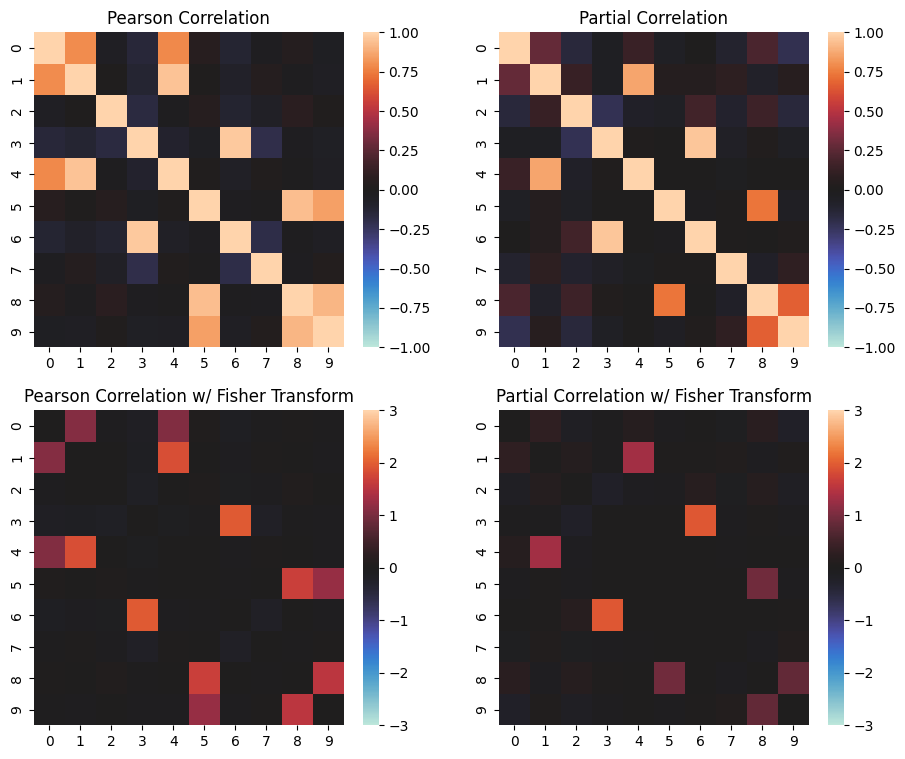

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [15]:
tuple_lst = [
    [2,10,1,1,10,1,1,1,1,1], # regions 1 and 4
    [1,1,1,1,1,10,1,1,10,2], # regions 5 and 8
    [1,1,1,10,1,1,10,1,1,1], # region 3 with region 6
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

In [16]:
# pcorr is never positive definite
for i in np.arange(100):
    tuple_lst = [
        [2,10,1,1,10,1,1,1,1,1], # regions 1 and 4
        [1,1,1,1,1,10,1,1,10,2], # regions 5 and 8
        [1,1,1,10,1,1,10,1,1,1], # region 3 with region 6
    ]

    df = gen_data2(tuple_lst,100)
    if positive_definite(df.pcorr()):
        plot_corr_pcorr(df)
        break

## Testing below

<AxesSubplot: >

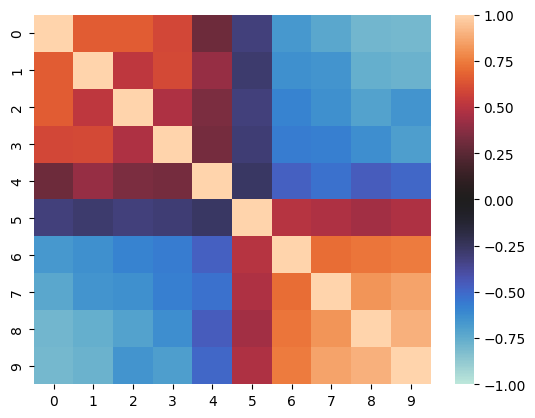

In [17]:
some_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        0.8,
        0.6,
        0.4,
        0.2,
        0
    ]
df = gen_data(some_lst,100)
sns.heatmap(df.corr(),**kwarg_dict)

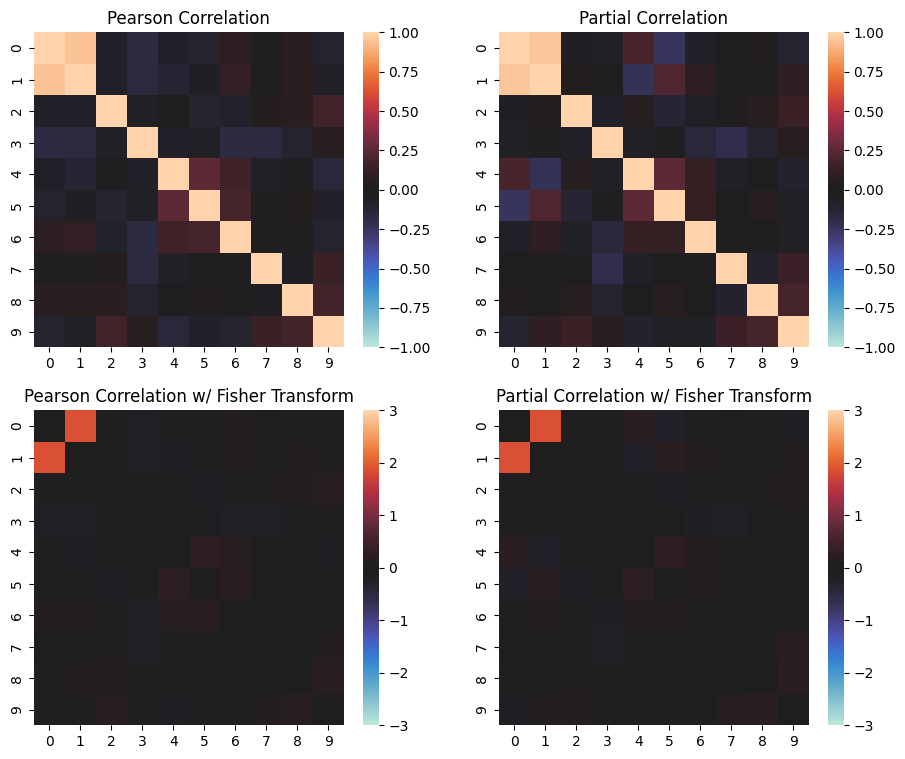

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


0         1         2         3         4         5         6  \
0  1.000000  0.952046 -0.077765 -0.172641 -0.076990 -0.104491  0.080818   
1  0.952046  1.000000 -0.072525 -0.162950 -0.127795 -0.048105  0.105177   
2 -0.077765 -0.072525  1.000000 -0.058358  0.003272 -0.124280 -0.087213   
3 -0.172641 -0.162950 -0.058358  1.000000 -0.085746 -0.060181 -0.179098   
4 -0.076990 -0.127795  0.003272 -0.085746  1.000000  0.256907  0.156775   
5 -0.104491 -0.048105 -0.124280 -0.060181  0.256907  1.000000  0.186000   
6  0.080818  0.105177 -0.087213 -0.179098  0.156775  0.186000  1.000000   
7 -0.035515 -0.033748  0.043322 -0.168630 -0.065027 -0.018614 -0.015899   
8  0.069762  0.075858  0.073934 -0.103468 -0.018846  0.035421  0.010693   
9 -0.104108 -0.066429  0.165623  0.050086 -0.152252 -0.084799 -0.102978   

          7         8         9  
0 -0.035515  0.069762 -0.104108  
1 -0.033748  0.075858 -0.066429  
2  0.043322  0.073934  0.165623  
3 -0.168630 -0.103468  0.050086  
4 -0.065027 -0.018846 -0.152252  
5 -0.018614  0.035421 -0.084799  
6 -0.015899  0.010693 -0.102978  
7  1.000000 -0.052134  0.138115  
8 -0.052134  1.000000  0.171005  
9  0.138115  0.171005  1.000000

array([[ 0.        ,  1.8531913 , -0.07792282, -0.17438782, -0.07714275,
        -0.10487422,  0.08099465, -0.03553022,  0.06987536, -0.10448615],
       [ 1.8531913 ,  0.        , -0.07265211, -0.16441615, -0.12849735,
        -0.0481423 ,  0.10556786, -0.03376059,  0.07600379, -0.06652688],
       [-0.07792282, -0.07265211,  0.        , -0.05842474,  0.00327164,
        -0.12492632, -0.08743474,  0.04334907,  0.07406934,  0.16716285],
       [-0.17438782, -0.16441615, -0.05842474,  0.        , -0.08595742,
        -0.06025358, -0.18105035, -0.17025616, -0.10384007,  0.05012777],
       [-0.07714275, -0.12849735,  0.00327164, -0.08595742,  0.        ,
         0.26279397,  0.15807897, -0.06511867, -0.01884791, -0.1534455 ],
       [-0.10487422, -0.0481423 , -0.12492632, -0.06025358,  0.26279397,
         0.        ,  0.18819052, -0.01861611,  0.03543547, -0.0850034 ],
       [ 0.08099465,  0.10556786, -0.08743474, -0.18105035,  0.15807897,
         0.18819052,  0.        , -0.01590001

In [18]:
tuple_lst = [
    [10000,10000,1,1,1,1,1,1,1,1]
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)
display(df.corr())
apply_fisher(df.corr())

In [19]:
testing = df.corr()
testing.loc[0][1]=0.999999
testing.loc[1][0]=0.999999
testing

C:\Users\Kickc\AppData\Local\Temp\ipykernel_10360\3688102171.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  testing.loc[0][1]=0.999999
C:\Users\Kickc\AppData\Local\Temp\ipykernel_10360\3688102171.py:3: FutureWarning: ChainedAssignmentEr

0         1         2         3         4         5         6  \
0  1.000000  0.999999 -0.077765 -0.172641 -0.076990 -0.104491  0.080818   
1  0.999999  1.000000 -0.072525 -0.162950 -0.127795 -0.048105  0.105177   
2 -0.077765 -0.072525  1.000000 -0.058358  0.003272 -0.124280 -0.087213   
3 -0.172641 -0.162950 -0.058358  1.000000 -0.085746 -0.060181 -0.179098   
4 -0.076990 -0.127795  0.003272 -0.085746  1.000000  0.256907  0.156775   
5 -0.104491 -0.048105 -0.124280 -0.060181  0.256907  1.000000  0.186000   
6  0.080818  0.105177 -0.087213 -0.179098  0.156775  0.186000  1.000000   
7 -0.035515 -0.033748  0.043322 -0.168630 -0.065027 -0.018614 -0.015899   
8  0.069762  0.075858  0.073934 -0.103468 -0.018846  0.035421  0.010693   
9 -0.104108 -0.066429  0.165623  0.050086 -0.152252 -0.084799 -0.102978   

          7         8         9  
0 -0.035515  0.069762 -0.104108  
1 -0.033748  0.075858 -0.066429  
2  0.043322  0.073934  0.165623  
3 -0.168630 -0.103468  0.050086  
4 -0.065027 -0.018846 -0.152252  
5 -0.018614  0.035421 -0.084799  
6 -0.015899  0.010693 -0.102978  
7  1.000000 -0.052134  0.138115  
8 -0.052134  1.000000  0.171005  
9  0.138115  0.171005  1.000000

<AxesSubplot: >

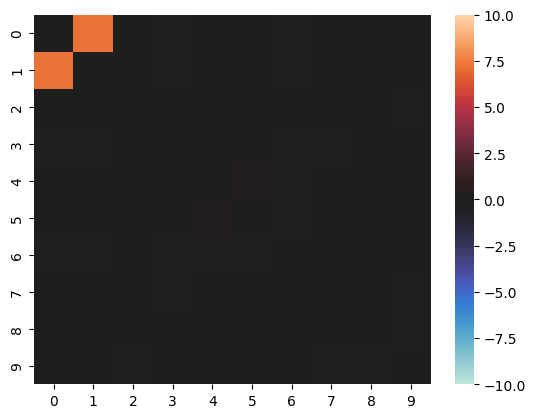

In [20]:
sns.heatmap(apply_fisher(testing),vmin=-10,vmax=10,center=0)

Text(0.5, 1.0, 'Pearson Correlation Matrix where Regions 0 \nand 1 are Positively Correlated')

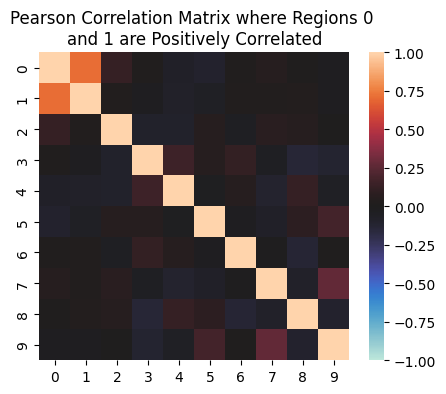

In [21]:
some_lst = [2,2,1,1,1,1,1,1,1,1] # arbitrary

df = gen_data(some_lst,100)
fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.heatmap(df.corr(),ax=ax,**kwarg_dict)
ax.set_title("Pearson Correlation Matrix where Regions 0 \nand 1 are Positively Correlated")

Text(0.5, 1.0, 'Pearson Correlation of Female Ideal Brain')

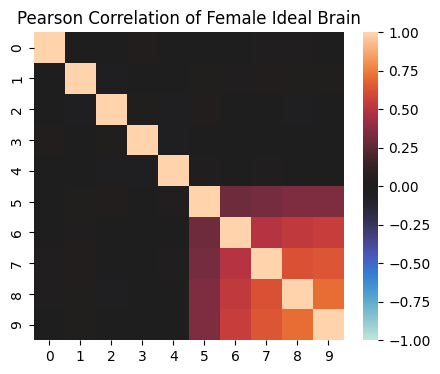

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
sns.heatmap(female_ideal[2],ax=ax,**kwarg_dict)
ax.set_title("Pearson Correlation of Female Ideal Brain")

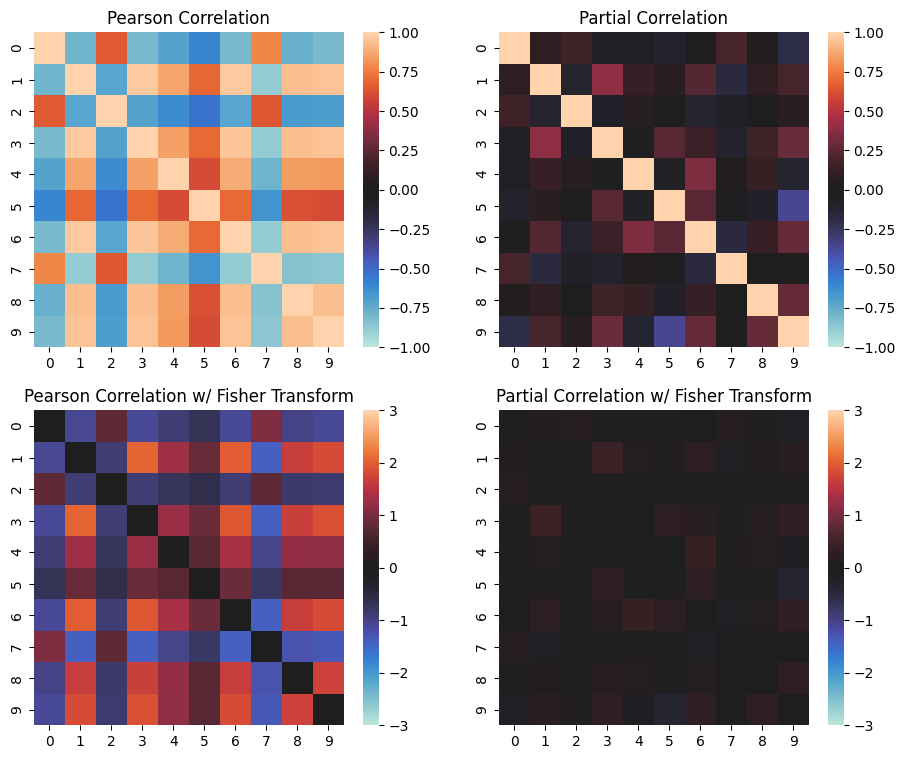

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [23]:
some_lst = [2,-1,1.5,-1,0.5,0.7,-0.3,2.5,0.2,0] # arbitrary

df = gen_data(some_lst,100)
# fig, ax = plt.subplots(1,1,figsize=(5,4))
# sns.heatmap(df.corr(),ax=ax,**kwarg_dict)
plot_corr_pcorr(df)

## Normal gen

In [24]:
def gen_data_normal(mult_lst,num_rows,num_features = 10):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.normal(1,0.1,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.2), axis=1)
    return df

In [25]:
df = gen_data_normal(male_lst,100)

<AxesSubplot: ylabel='Count'>

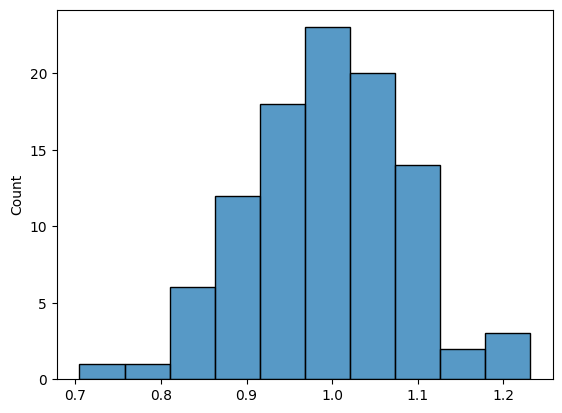

In [26]:
sns.histplot(np.random.normal(1,0.1,100))

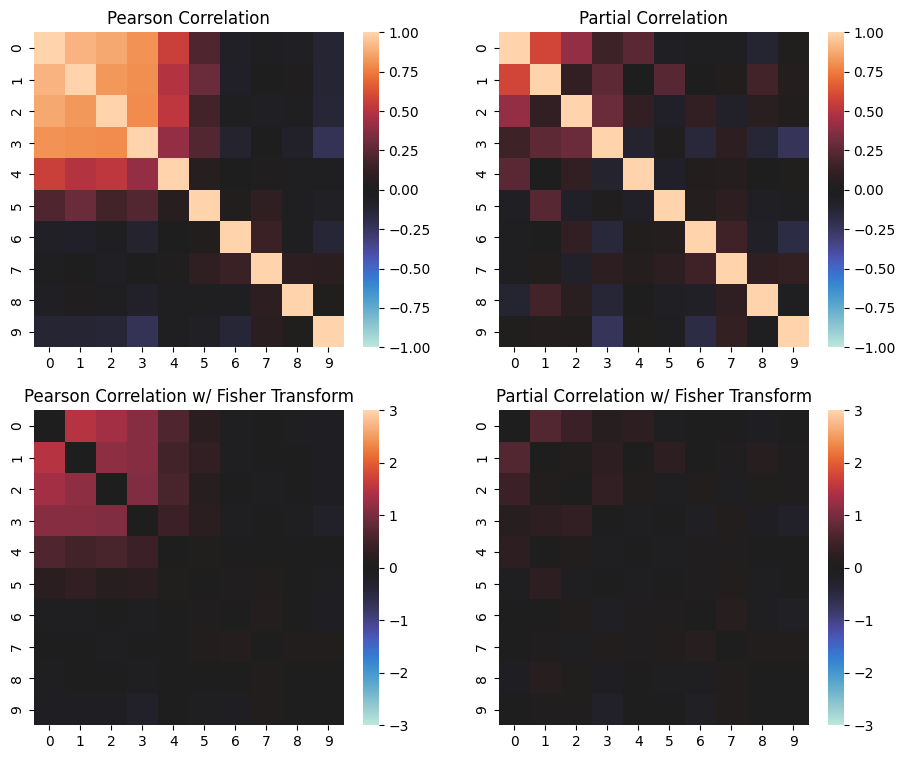

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [27]:
plot_corr_pcorr(df)

## 100 Regions

Using 100 regions, 200 time points per region, running into issues with positive definite partial correlations

In [28]:
len(np.arange(10,1,-0.18))

50

[10.    9.82  9.64  9.46  9.28  9.1   8.92  8.74  8.56  8.38  8.2   8.02
  7.84  7.66  7.48  7.3   7.12  6.94  6.76  6.58  6.4   6.22  6.04  5.86
  5.68  5.5   5.32  5.14  4.96  4.78  4.6   4.42  4.24  4.06  3.88  3.7
  3.52  3.34  3.16  2.98  2.8   2.62  2.44  2.26  2.08  1.9   1.72  1.54
  1.36  1.18  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    1.    1.    1.  ]


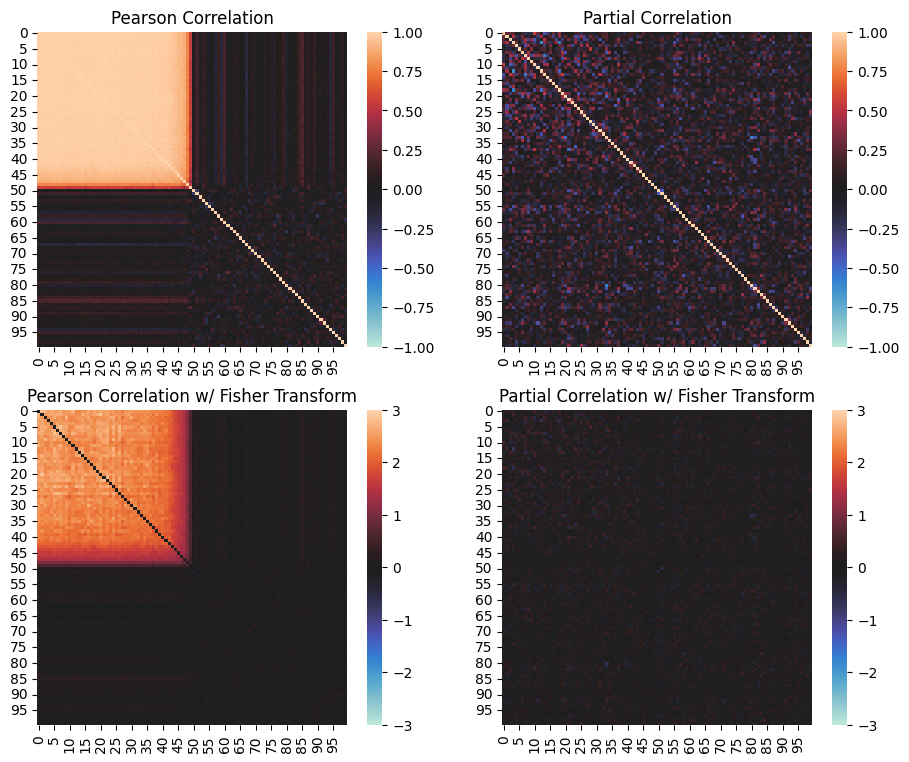

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [29]:
male_lst_100 = np.concatenate([np.arange(10,1,-0.18),[1]*50])
print(male_lst_100)
df = gen_data_normal(male_lst_100,num_rows=150,num_features=100)
plot_corr_pcorr(df)

[1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.18 1.36 1.54 1.72 1.9
 2.08 2.26 2.44 2.62 2.8  2.98 3.16 3.34 3.52 3.7  3.88 4.06 4.24 4.42
 4.6  4.78 4.96 5.14 5.32 5.5  5.68 5.86 6.04 6.22 6.4  6.58 6.76 6.94
 7.12 7.3  7.48 7.66 7.84 8.02 8.2  8.38 8.56 8.74 8.92 9.1  9.28 9.46
 9.64 9.82]


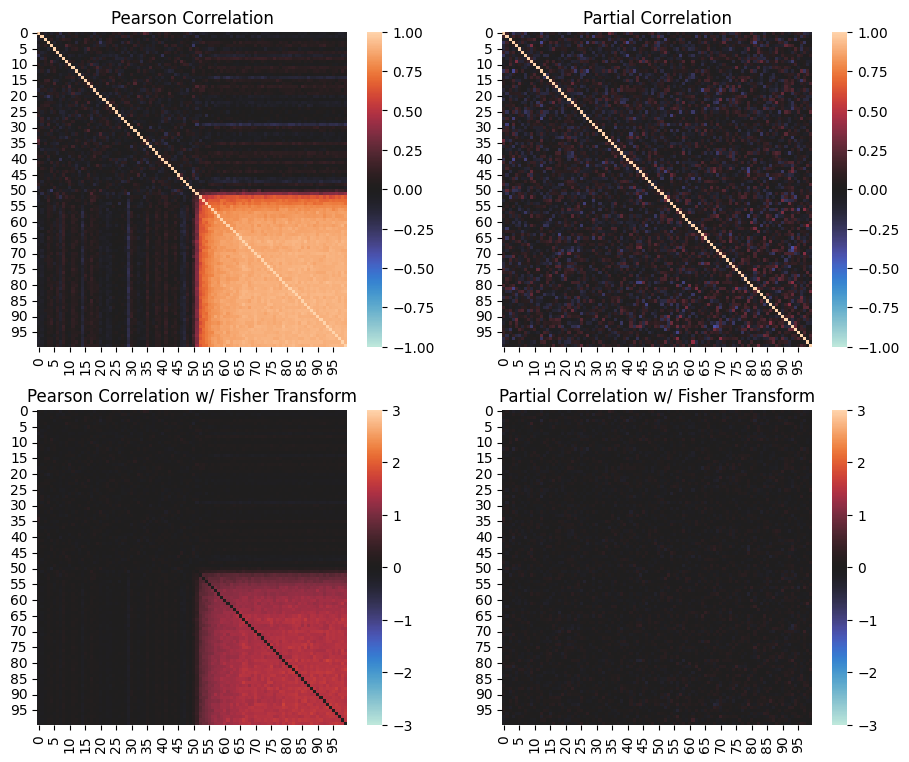

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [30]:
female_lst_100 = np.concatenate([[1]*50,np.arange(1,10,0.18)])
print(female_lst_100)
df = gen_data(female_lst_100,200,100)
plot_corr_pcorr(df)

In [31]:
# simulated_subjects_100 = []
# test = 0

# while len(simulated_subjects_100) < 500:
#     df = gen_data_normal(male_lst_100,100,100)
#     c = df.corr()
#     p = df.pcorr()
#     fc = apply_fisher(c)
#     fpc = apply_fisher(p)
#     if (not positive_definite(c)) or (not positive_definite(p)):
#         test +=1
#         continue
#     print(test)
#     simulated_subjects_100 += [('M',df,c,p,fc,fpc)]

##  brute force test

In [32]:
def gen_data_brute(mult_lst,num_rows,chance,num_features = 10):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,chance), axis=1)
    return df

In [33]:
def get_corr(lst,chance):
    df = gen_data_brute(male_lst,100,chance,10)
    numpied = df.corr().to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.abs(numpied).mean()

In [34]:
get_corr(male_lst,0.6)

0.15120544173040104

[Text(0.5, 0, 'p'), Text(0, 0.5, 'Mean Correlation Coefficient')]

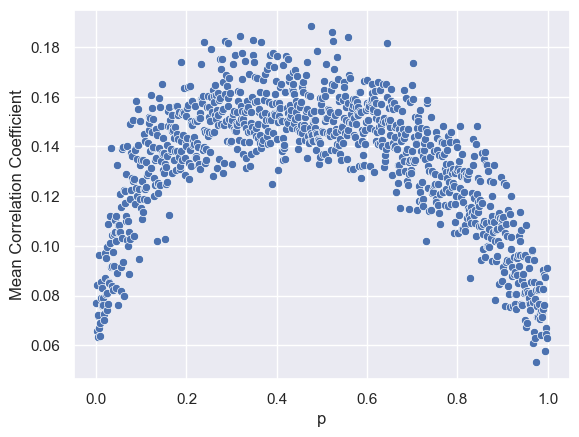

In [35]:
xVals = []
yVals = []
for x in np.arange(0,1,0.001):
    xVals += [x]
    yVals += [get_corr(female_lst,x)]
    
data = pd.DataFrame(np.array([xVals,yVals]).T)
data.columns = ['x','y']
sns.set_theme()
ax = sns.scatterplot(data,x='x',y='y')
ax.set(xlabel='p', ylabel='Mean Correlation Coefficient')

## Revised Gen

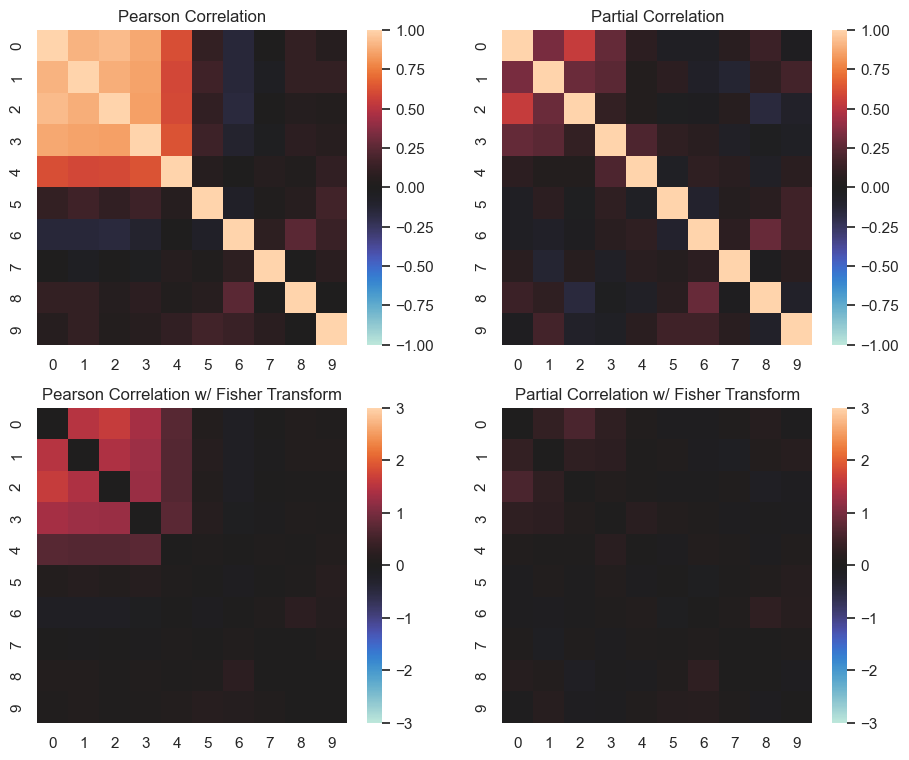

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [36]:
def gen_data_revised(active_weights,num_rows,num_features = 10,active_proportion = 0.4):
    # generate dataframe of gaussian noise
    df = pd.DataFrame(np.random.normal(1,0.1,size=(num_rows, num_features)))
    
    # split into active and inactive sets
    split_index = int(df[0].size * active_proportion)
    active, inactive = df.iloc[:split_index],df.iloc[split_index:]
    
    # multiply active set by diagonal matrix of weights
    active_mult = np.matmul(active,np.diag(active_weights))
    
    # join the two sets
    return pd.concat([active_mult,inactive])

df = gen_data_revised(male_lst,100)
plot_corr_pcorr(df)

## Sliding Weights

Plan is to generate weights from a distribution and shift the mean

In [37]:
n_features = 100
max_amp = 2
min_amp = 1

lst = []
half = n_features//2
lst += [1]*half
x_lst = np.concatenate([np.arange(1,half+1,1),np.arange(half,min_amp-1,-1)])
for i in x_lst:
    lst += [min_amp + (i/half) * (max_amp-min_amp)]
lst += [1]*half
# lst

In [38]:
len(lst)

200

In [39]:
lst[100]

2.0

In [40]:
i1=100
i2=0

print(lst[i1:i1+n_features])
print(lst[i2:i2+n_features])

[2.0, 1.98, 1.96, 1.94, 1.92, 1.9, 1.88, 1.8599999999999999, 1.8399999999999999, 1.8199999999999998, 1.8, 1.78, 1.76, 1.74, 1.72, 1.7, 1.6800000000000002, 1.6600000000000001, 1.6400000000000001, 1.62, 1.6, 1.58, 1.56, 1.54, 1.52, 1.5, 1.48, 1.46, 1.44, 1.42, 1.4, 1.38, 1.3599999999999999, 1.34, 1.32, 1.3, 1.28, 1.26, 1.24, 1.22, 1.2, 1.18, 1.16, 1.1400000000000001, 1.12, 1.1, 1.08, 1.06, 1.04, 1.02, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.1400000000000001, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.3599999999999999, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.62, 1.6400000000000001, 1.6600000000000001, 1.6800000000000002, 1.7, 1.72, 1.74, 1.76, 1.78,

In [41]:
def gen_weights_simple(n_features,max_amp,min_amp,i1,i2):
    lst = []
    half = n_features//2
    lst += [min_amp]*n_features # add 1s
    
    # add slope up then down
    x_lst = np.concatenate([np.arange(1,half+1,1),np.arange(half,min_amp-1,-1)])
    for i in x_lst:
        lst += [min_amp + (i/half) * (max_amp-min_amp)]
        
    lst += [min_amp]*n_features # add 1s
    
    return lst[i1:i1+n_features],lst[i2:i2+n_features]

<AxesSubplot: >

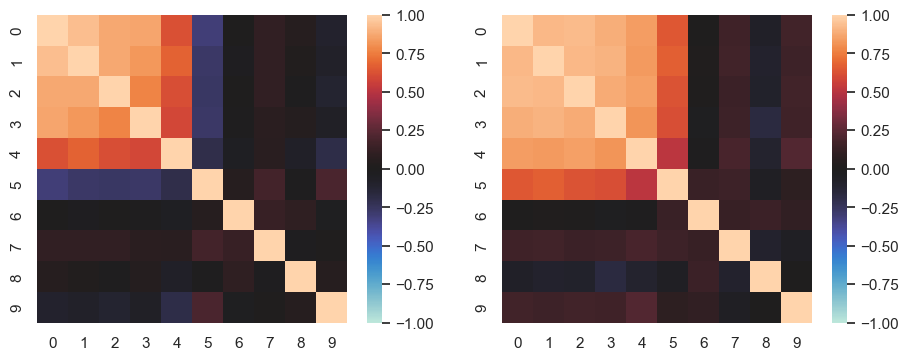

In [42]:
i1 = 15
i2 = 14
mw,fw = gen_weights_simple(10,2,1,i1,i2)
m1 = gen_data_revised(mw,100)
f1 = gen_data_revised(fw,100)

fig, ax = plt.subplots(1,2,figsize=(11,4))
sns.heatmap(m1.corr(), ax=ax[0],**kwarg_dict)
sns.heatmap(f1.corr(), ax=ax[1],**kwarg_dict)

## Complex Weights

In [43]:
# b shifts the "hump" along x axis
def f1(x,a,b,freq,amp):
    return (amp*(np.e**(-0.5*((x-b)/a)**2)))*np.cos(freq*2*np.pi*x)/(a*np.sqrt(2*np.pi)) +1
def gen_noise(n,s):
    return np.random.normal(0,s,size=n)
def test_func_args(func,args,s=0.05):
    x = np.arange(-10,10,0.1)
    y = func(x,**args,b=0)
    noise = gen_noise(len(x),s)
    sns.lineplot(x=x,y=y+noise)

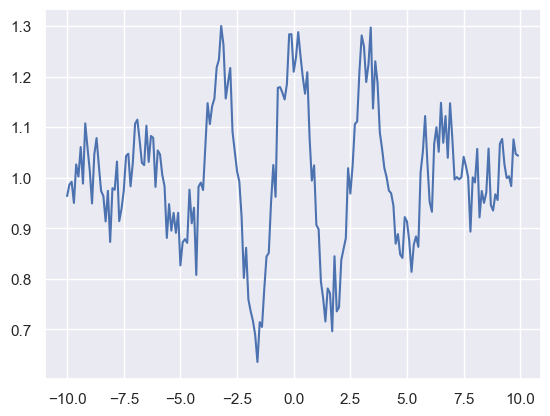

In [44]:
# for 10 features
arg10 = {'a':4,'freq':0.3,'amp':3}
test_func_args(f1,arg10)

In [45]:
def test_complex(weight_func,func_args,num_f,b1,b2,plot=True,s=0.05):
    num_orig = 10

    x = np.arange(-5,15,0.1)
    y1 = weight_func(x,**func_args,b=b1)
    noise1 = gen_noise(len(x),s)
    y2 = weight_func(x,**func_args,b=b2)
    noise2 = gen_noise(len(x),s)

    if plot:
        df = pd.DataFrame({
            'x': x, 
            'A': y1+noise1,
            'B': y2+noise2
        })
        ax = sns.lineplot(data=pd.melt(df, ['x']),x='x',y='value',hue='variable')

    w1 = weight_func(np.arange(0,num_orig,num_orig/num_f),**func_args,b=b1)
    df1 = gen_data_revised(w1,100,num_features = num_f)
    w2 = weight_func(np.arange(0,num_orig,num_orig/num_f),**func_args,b=b2)
    df2 = gen_data_revised(w2,100,num_features = num_f)
    corr1 = df1.corr();
    corr2 = df2.corr();
    if plot:
        display(pd.DataFrame([w1,w2]))

        fig, ax = plt.subplots(1,2,figsize=(11,4))
        sns.heatmap(corr1,ax=ax[0],**kwarg_dict)
        ax[0].set_title("Correlation of A")
        sns.heatmap(corr2,ax=ax[1],**kwarg_dict)
        ax[1].set_title("Correlation of B")
        print("b1:",b1)
        print("b2:",b2)
        
    adj = 1.26
    if num_f == 100:
        adj = 13.2
    
    norm = np.linalg.norm((corr1 - corr2))
    adj_norm = norm / adj
    
    pcorr_norm = np.linalg.norm((df1.pcorr()-df2.pcorr()))
    
    if plot:
        print('Norm:',norm)
        print('Adjusted:',adj_norm)
        print('Pcorr norm:',pcorr_norm)
    else:
        return np.abs(b1-b2),norm,adj_norm,pcorr_norm

0         1         2         3         4         5         6  \
0  1.290001  0.907540  0.765384  1.213620  1.069792  0.818522  1.042331   
1  1.264049  0.910385  0.757937  1.234616  1.081596  0.774147  1.056080   

          7         8         9  
0  1.078586  0.947650  0.987487  
1  1.110825  0.921414  0.980004

b1: 1
b2: 2
Norm: 1.4025795239249597
Adjusted: 1.1131583523213966
Pcorr norm: 1.441893233962377


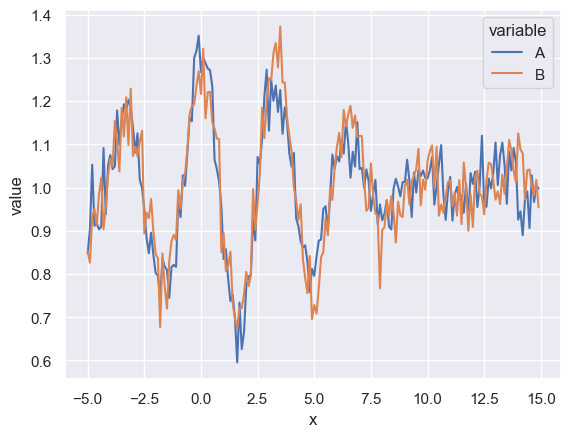

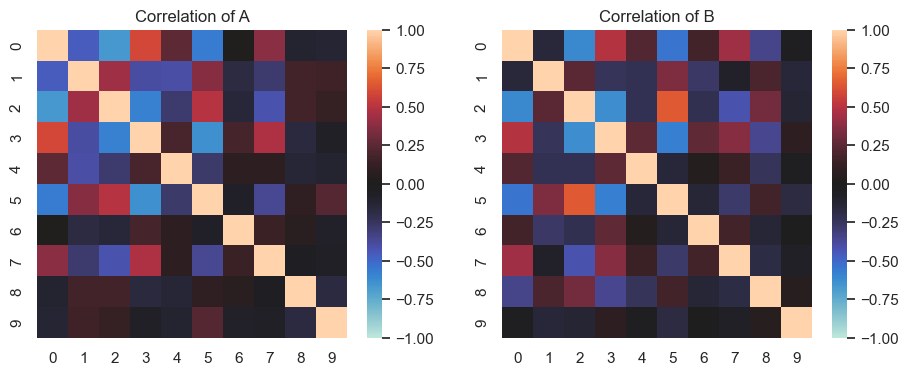

In [46]:
test_complex(f1,arg10,10,1,2,s=0.05)

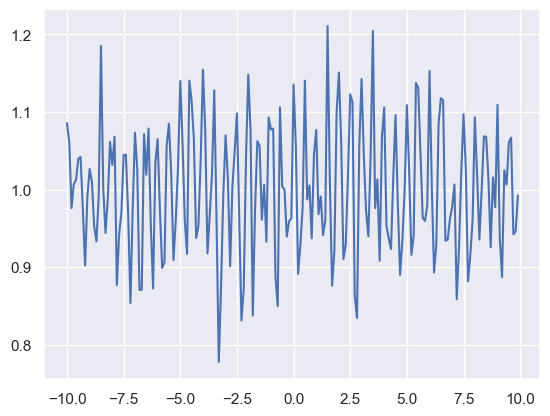

In [47]:
arg100 = {'a':10,'freq':2,'amp':3}
test_func_args(f1,arg100)

0         1         2         3         4         5         6   \
0  1.119683  1.036982  0.903194  0.903218  1.036954  1.119533  1.036917   
1  1.105620  1.032800  0.913710  0.913300  1.033271  1.108158  1.033572   

         7         8         9   ...        90        91        92        93  \
0  0.903412  0.903484  1.036835  ...  1.079826  1.024445  0.936584  0.937168   
1  0.911725  0.911349  1.034003  ...  1.110481  1.034003  0.911349  0.911725   

         94        95        96        97        98        99  
0  1.023776  1.076218  1.023329  0.939511  0.940098  1.022656  
1  1.033572  1.108158  1.033271  0.913300  0.913710  1.032800  

[2 rows x 100 columns]

b1: 0
b2: 5
Norm: 14.169632309479788
Adjusted: 1.0734569931424083
Pcorr norm: 96.31590457801151


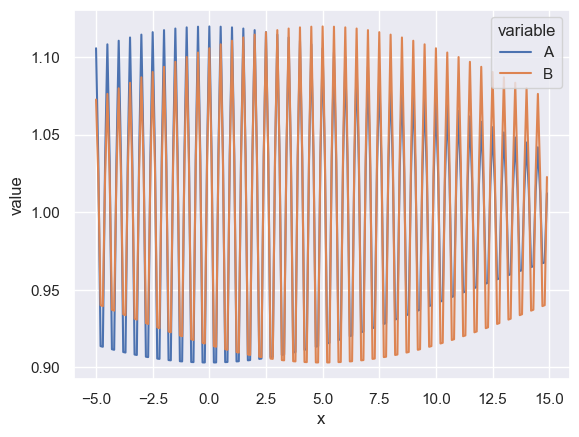

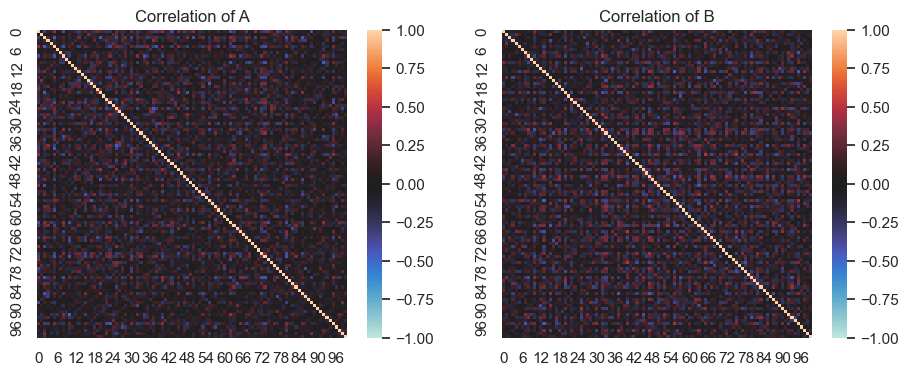

In [48]:
test_complex(f1,arg100,100,0,5,s=0)

In [49]:
def f2(x,a,b,freq,amp):
    return ((np.e**(-0.5*((x-b)/a)**2))*0.05*np.sin(np.pi*x)+1) * f1(x,a,b,freq,amp)

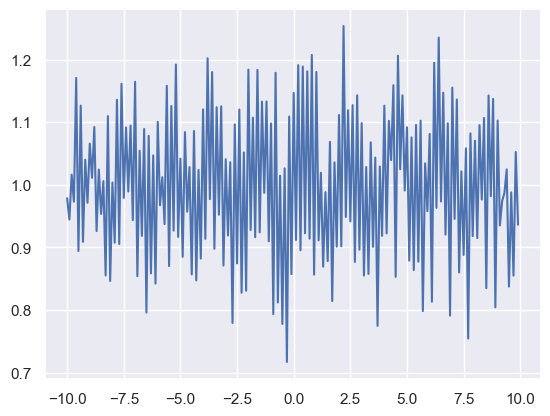

In [50]:
arg100b = {'a':10,'freq':5,'amp':3}
test_func_args(f2,arg100b)

0         1         2         3         4         5         6   \
0  1.119683  0.893924  1.152558  0.915967  1.172784  0.924435  1.172606   
1  1.072591  0.935454  1.093571  0.948613  1.107753  0.953197  1.109864   

         7         8         9   ...        90        91        92        93  \
0  0.916144  1.152091  0.894355  ...  1.079826  0.911489  1.057629  0.898125   
1  0.946546  1.099143  0.930298  ...  1.119086  0.867247  1.086510  0.845076   

         94        95        96        97        98        99  
0  1.044019  0.894368  1.043234  0.901851  1.054515  0.917912  
1  1.066329  0.836498  1.066390  0.844775  1.086759  0.866722  

[2 rows x 100 columns]

b1: 0
b2: 10
Norm: 14.367783697093385
Adjusted: 1.088468461901014
Pcorr norm: 77.98385407844667


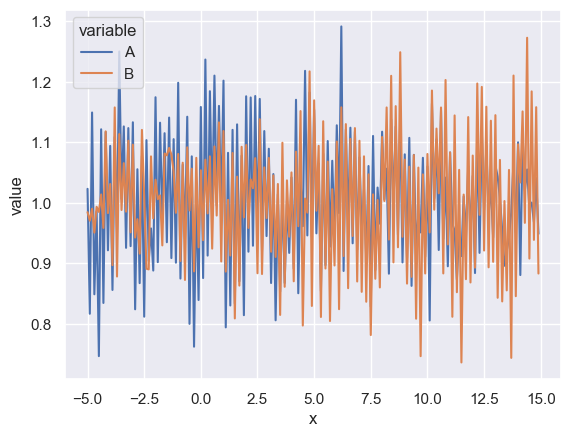

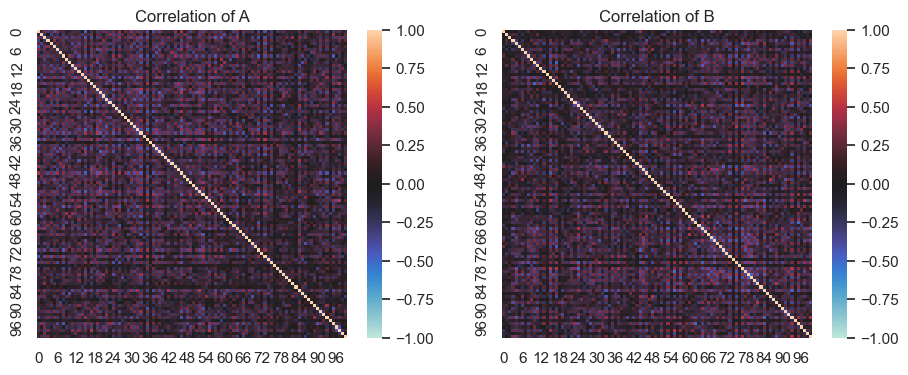

In [51]:
test_complex(f2,arg100b,100,0,10,s=0.05)

In [52]:
test = []
for i in np.arange(-5,15,0.5):
    for j in np.arange(-5,15,0.5):
        a = test_complex(f1,arg100,100,i,j,False)
        test += [[a[0],a[1],a[2]]]

dist       norm       adj
0   0.0  14.019122  1.062055
1   0.5  13.641096  1.033416
2   1.0  14.229014  1.077956
3   1.5  14.258434  1.080184
4   2.0  14.348523  1.087009

<AxesSubplot: xlabel='dist', ylabel='adj'>

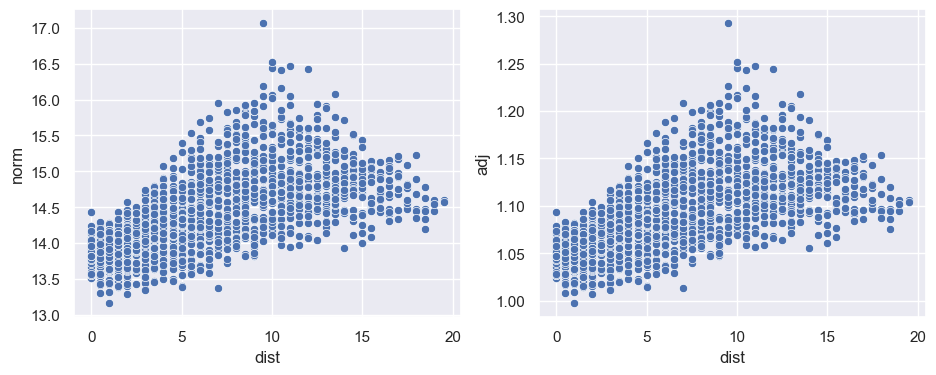

In [53]:
test_df=pd.DataFrame(test)
test_df.columns = ['dist','norm','adj']
display(test_df.head())
fig, ax = plt.subplots(1,2,figsize=(11,4))
sns.scatterplot(test_df,x='dist',y='norm',ax=ax[0])
sns.scatterplot(test_df,x='dist',y='adj',ax=ax[1])

In [54]:
test10 = []
for i in np.arange(-5,15,0.05):
    a = test_complex(f1,arg10,10,i,i,False,s=0)
    test10 += [a[1]]
np.mean(test10) # 1.26

1.26546781738171

In [55]:
test100 = []
for i in np.arange(-5,15,0.05):
    a = test_complex(f1,arg100,100,i,i,False,s=0)
    test100 += [a[1]]
np.mean(test100) # 13.2

13.889039154910812

## Testing varying frequencies

0         1         2         3         4         5         6   \
0  1.119683  1.117557  1.111256  1.101006  1.087175  1.070260  1.050867   
1  1.105620  1.104264  1.099170  1.090485  1.078486  1.063574  1.046257   

         7         8         9   ...        90        91        92        93  \
0  1.029691  1.007491  0.985060  ...  0.975333  0.990085  1.004922  1.019314   
1  1.027136  1.006881  0.986209  ...  0.965859  0.986209  1.006881  1.027136   

         94        95        96        97        98        99  
0  1.032760  1.044800  1.055032  1.063129  1.068843  1.072018  
1  1.046257  1.063574  1.078486  1.090485  1.099170  1.104264  

[2 rows x 100 columns]

b1: 0
b2: 5
Norm: 14.088785971262617
Adjusted: 1.0673322705501982
Pcorr norm: 86.18887749067659


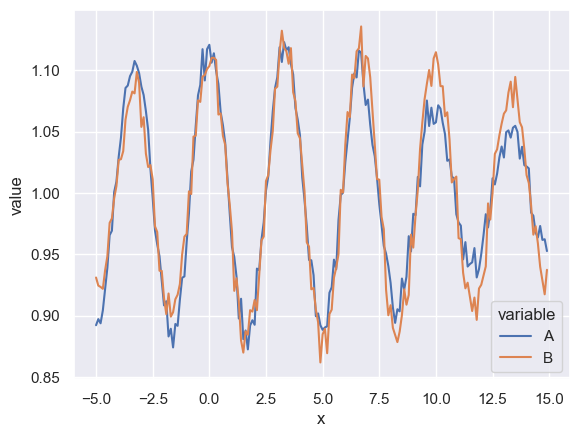

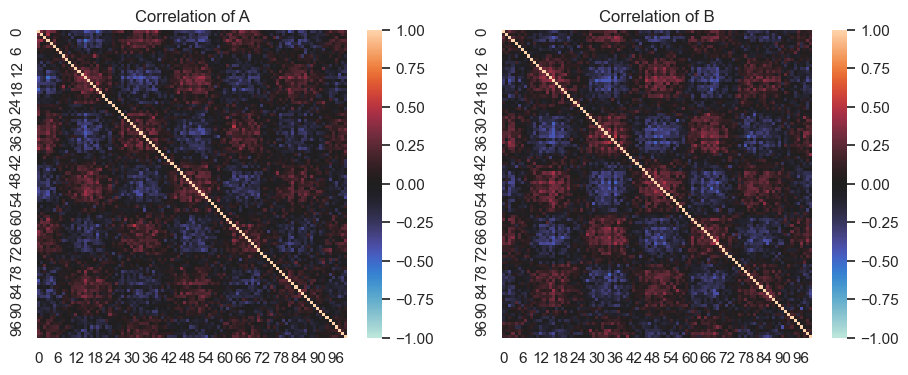

In [56]:
arg100c = {'a':10,'freq':0.3,'amp':3}
test_complex(f1,arg100c,100,0,5,s=0.01)

- use amp and b for variables
- try changing freq
- check paper for actual difference

In [57]:
def f3(x,b,f1,s1,f2,s2,f3,s3,amp,width):
    return amp*(f1*np.sin(s1*x)+f2*np.sin(s2*np.e*x)+f3*np.sin(s3*np.pi*x)) * \
           ((2*np.pi)**(-1/2)) * np.e**(-0.5*((x-b)/width)**2) + 1
def test_func_args2(func,args,s=0.05,dist=0):
    x = np.arange(-10,10,0.1)
    y = func(x,dist,**args)
    noise = gen_noise(len(x),s)
    sns.lineplot(x=x,y=y+noise)

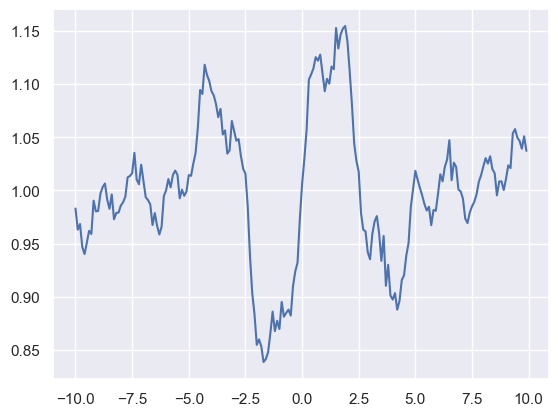

In [58]:
arg100d = {'f1':0.2,'s1':1.4,'f2':0.1,'s2':1.5,'f3':0.2,'s3':0.3,'amp':1,'width':7}
test_func_args2(f3,arg100d,s=0.01,dist=0)

0         1         2         3         4         5         6         7   \
0  1.0  1.026974  1.052209  1.073676  1.089909  1.100226  1.104824  1.104729   
1  1.0  1.026974  1.052209  1.073676  1.089909  1.100226  1.104824  1.104729   

         8         9   ...       90        91        92        93        94  \
0  1.101608  1.097475  ...  1.02855  1.043203  1.059993  1.076687  1.090974   
1  1.101608  1.097475  ...  1.02855  1.043203  1.059993  1.076687  1.090974   

         95        96        97        98        99  
0  1.100835  1.104849  1.102416  1.093827  1.080203  
1  1.100835  1.104849  1.102416  1.093827  1.080203  

[2 rows x 100 columns]

b1: 5
b2: 5
Norm: 14.158617734848514
Adjusted: 1.072622555670342
Pcorr norm: 91.87736717661271


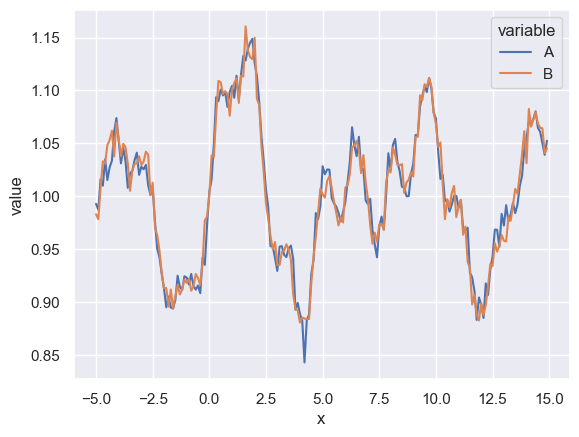

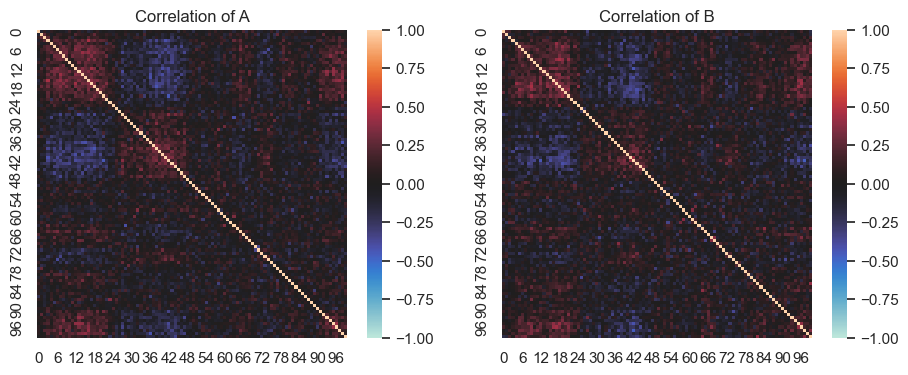

In [59]:
test_complex(f3,arg100d,100,5,5,s=0.01)

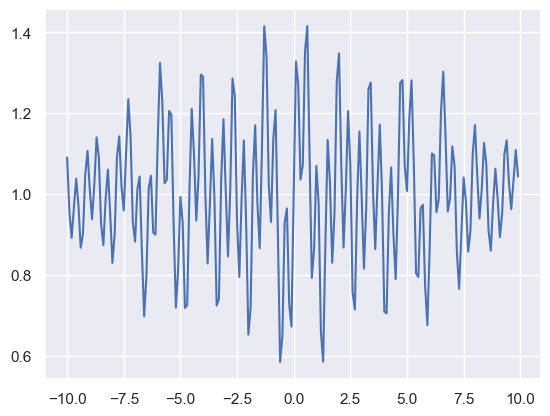

In [60]:
arg100e = {'f1':1.9,'s1':3,'f2':6,'s2':5,'f3':4.5,'s3':1.3,'amp':0.1,'width':7}
test_func_args2(f3,arg100e,s=0.00,dist=0)

0         1         2         3         4         5         6         7   \
0  1.0  1.327688  1.271883  1.035542  1.070407  1.352046  1.415334  1.093721   
1  1.0  1.120550  1.102082  1.013620  1.027536  1.140526  1.169207  1.038969   

         8         9   ...        90        91        92        93        94  \
0  0.792486  0.863648  ...  0.988919  0.893428  0.951605  1.098701  1.132821   
1  0.911937  0.940943  ...  0.974933  0.753944  0.885961  1.237375  1.326022   

         95        96        97        98        99  
0  1.027581  0.962124  1.033258  1.108663  1.043417  
1  1.069096  0.903158  1.086789  1.289409  1.118020  

[2 rows x 100 columns]

b1: 0
b2: 10
Norm: 17.651244574601304
Adjusted: 1.3372154980758564
Pcorr norm: 88.78664845743661


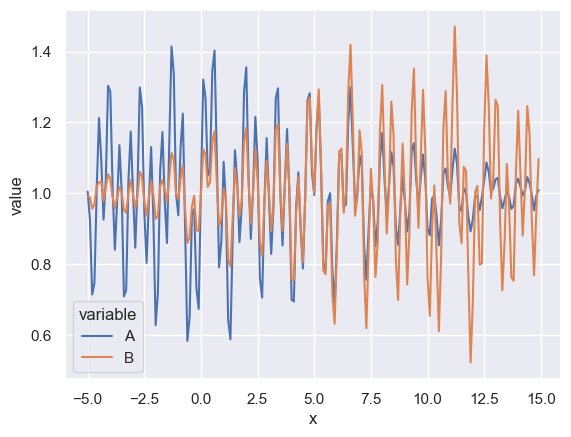

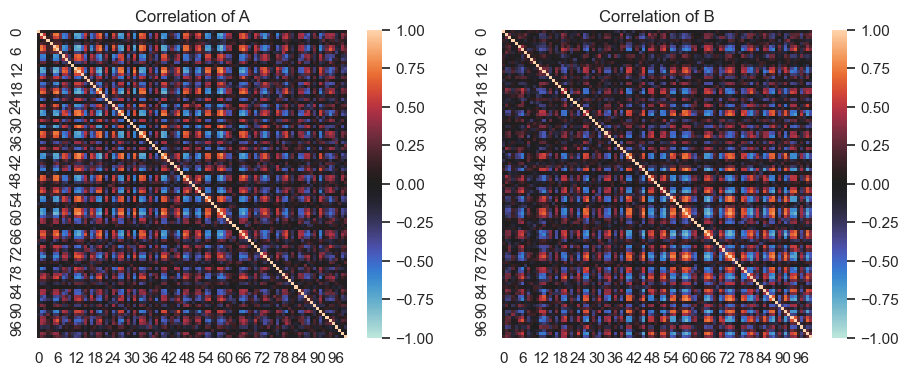

In [244]:
test_complex(f3,arg100e,100,0,10,s=0.01)

- moving b is only changing the amplitude, not translating the weight function

In [62]:
test100e = []
for i in np.arange(-5,15,0.01):
    a = test_complex(f3,arg100e,100,i,i,False,s=0)
    test100e += [a[3]]
np.mean(test100e) # 12.93

80.30843803903215

<AxesSubplot: ylabel='Count'>

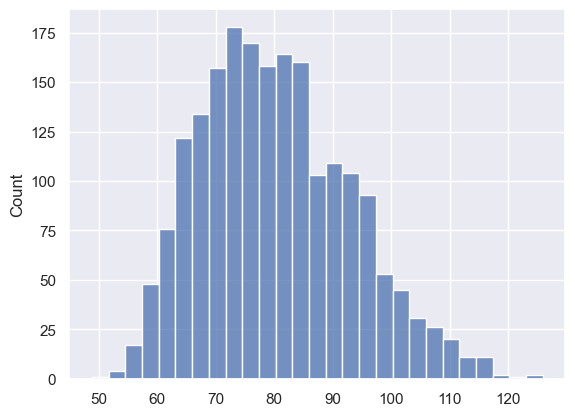

In [63]:
sns.histplot(test100e)

## Testing noise

In [64]:
def f4(x,b):
    return [1]*len(x)

0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  96  \
0   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   
1   1   1   1   1   1   1   1   1   1   1  ...   1   1   1   1   1   1   1   

   97  98  99  
0   1   1   1  
1   1   1   1  

[2 rows x 100 columns]

b1: 0
b2: 0
Norm: 14.02775098657599
Adjusted: 1.0627084080739386
Pcorr norm: 84.45445982247384


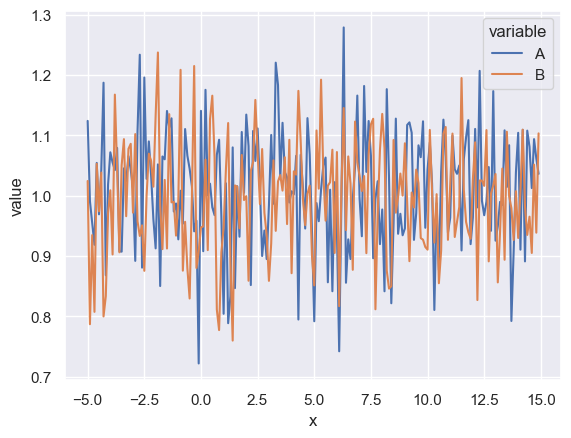

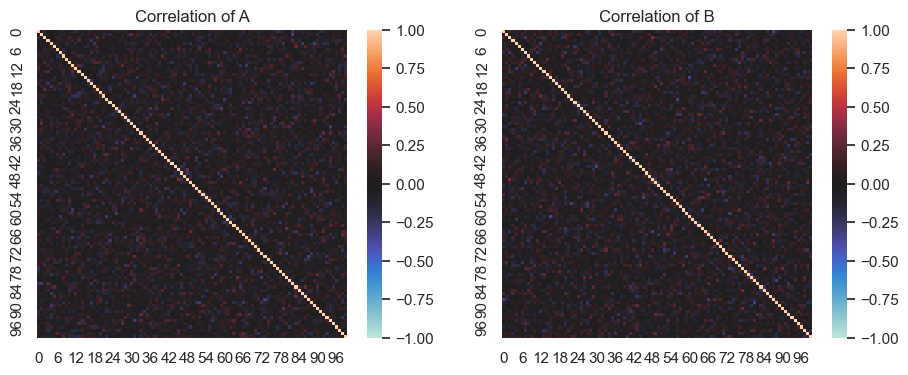

In [65]:
test_complex(f4,{},100,0,0,s=0.1)

Using f3 and arg100e

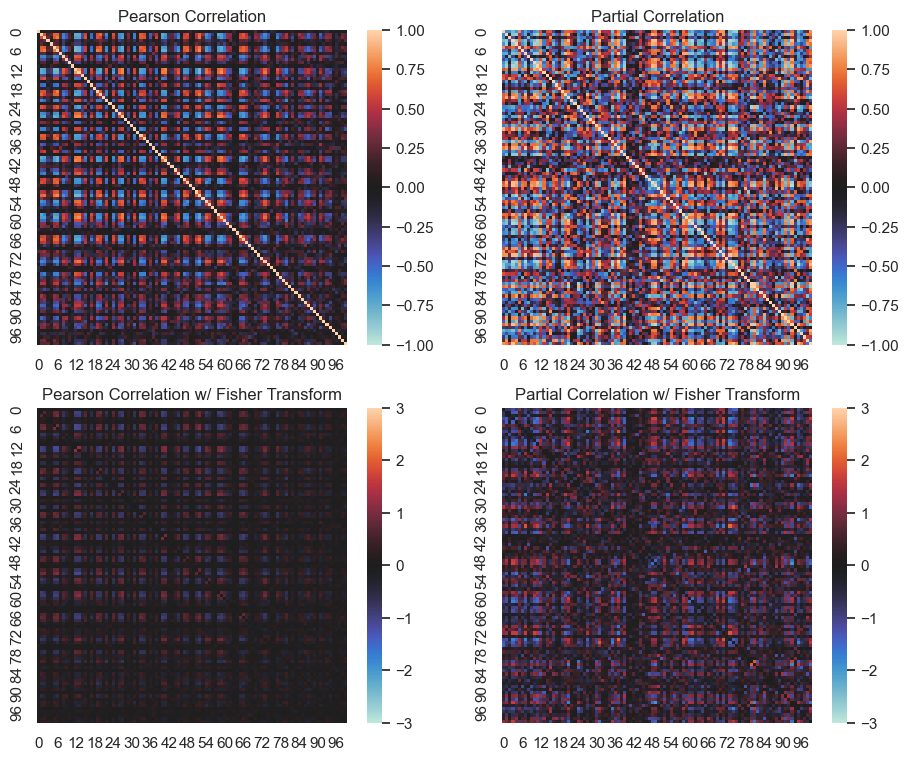

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [66]:
num_f = 100
b = 0
func = f3
func_args = arg100e

w = func(np.arange(0,10,0.1),**func_args,b=b)
df = gen_data_revised(w,100,num_features = num_f)
plot_corr_pcorr(df)

In [67]:
test = []
for i in np.arange(-5,15,0.5):
    for j in np.arange(-5,15,0.5):
        a = test_complex(f3,arg100e,100,i,j,False)
        test += [[a[0],a[1],a[2],a[3]]]

dist       norm       adj      pcorr
0   0.0  14.001316  1.060706  70.557072
1   0.5  14.095822  1.067865  95.877765
2   1.0  14.322979  1.085074  97.894451
3   1.5  14.881355  1.127375  85.964439
4   2.0  15.975185  1.210241  78.859265

<AxesSubplot: xlabel='dist', ylabel='pcorr'>

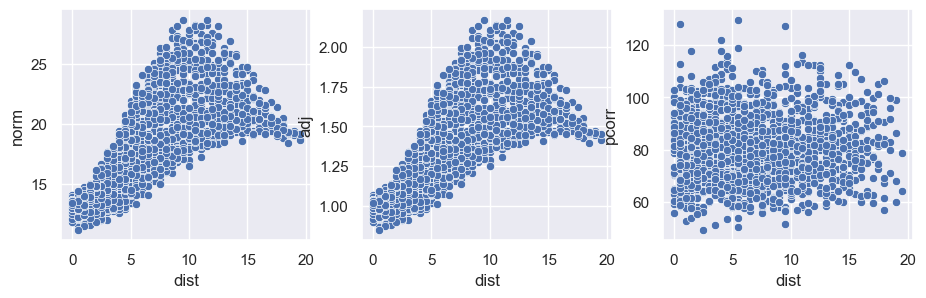

In [68]:
test_df=pd.DataFrame(test)
test_df.columns = ['dist','norm','adj','pcorr']
display(test_df.head())
fig, ax = plt.subplots(1,3,figsize=(11,3))
sns.scatterplot(test_df,x='dist',y='norm',ax=ax[0])
sns.scatterplot(test_df,x='dist',y='adj',ax=ax[1])
sns.scatterplot(test_df,x='dist',y='pcorr',ax=ax[2])

In [69]:
def test_complex_pcorr(weight_func,func_args,num_f,b1,b2,plot=True,s=0.05):
    num_orig = 10

    x = np.arange(-5,15,0.1)
    y1 = weight_func(x,**func_args,b=b1)
    noise1 = gen_noise(len(x),s)
    y2 = weight_func(x,**func_args,b=b2)
    noise2 = gen_noise(len(x),s)

    if plot:
        df = pd.DataFrame({
            'x': x, 
            'A': y1+noise1,
            'B': y2+noise2
        })
        ax = sns.lineplot(data=pd.melt(df, ['x']),x='x',y='value',hue='variable')

    w1 = weight_func(np.arange(0,num_orig,num_orig/num_f),**func_args,b=b1)
    df1 = gen_data_revised(w1,100,num_features = num_f)
    w2 = weight_func(np.arange(0,num_orig,num_orig/num_f),**func_args,b=b2)
    df2 = gen_data_revised(w2,100,num_features = num_f)
    corr1 = df1.pcorr();
    corr2 = df2.pcorr();
    if plot:
        display(pd.DataFrame([w1,w2]))

        fig, ax = plt.subplots(1,2,figsize=(11,4))
        sns.heatmap(corr1,ax=ax[0],**kwarg_dict)
        ax[0].set_title("Correlation of A")
        sns.heatmap(corr2,ax=ax[1],**kwarg_dict)
        ax[1].set_title("Correlation of B")
        print("b1:",b1)
        print("b2:",b2)
        
    norm = np.linalg.norm((corr1 - corr2))
    
    if plot:
        print('Norm:',norm)
    else:
        return np.abs(b1-b2),norm

0         1         2         3         4         5         6         7   \
0  1.0  1.327688  1.271883  1.035542  1.070407  1.352046  1.415334  1.093721   
1  1.0  1.120550  1.102082  1.013620  1.027536  1.140526  1.169207  1.038969   

         8         9   ...        90        91        92        93        94  \
0  0.792486  0.863648  ...  0.988919  0.893428  0.951605  1.098701  1.132821   
1  0.911937  0.940943  ...  0.974933  0.753944  0.885961  1.237375  1.326022   

         95        96        97        98        99  
0  1.027581  0.962124  1.033258  1.108663  1.043417  
1  1.069096  0.903158  1.086789  1.289409  1.118020  

[2 rows x 100 columns]

b1: 0
b2: 10
Norm: 18.648923519187456
Adjusted: 1.41279723630208
Pcorr norm: 75.3659216349599


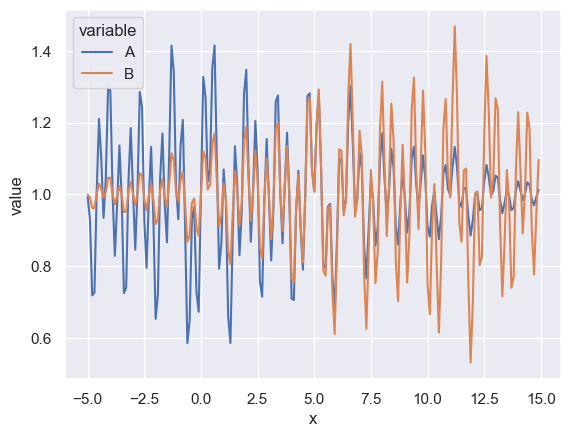

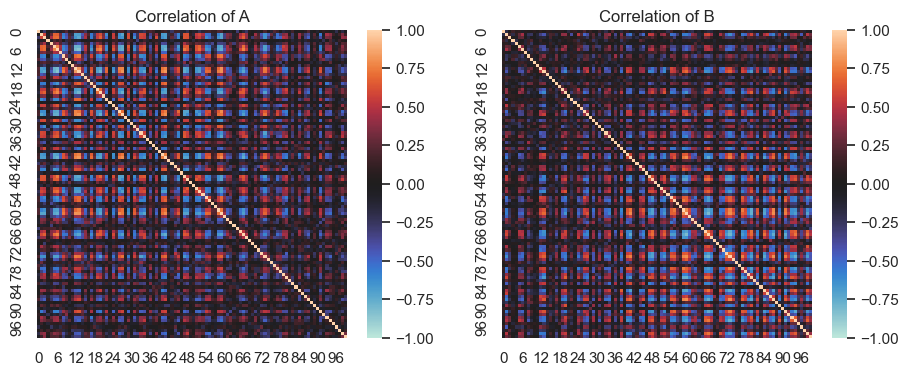

In [143]:
test_complex(f3,arg100e,100,0,10,s=0.0)

0         1         2         3         4         5         6         7   \
0  1.0  1.327688  1.271883  1.035542  1.070407  1.352046  1.415334  1.093721   
1  1.0  1.327688  1.271883  1.035542  1.070407  1.352046  1.415334  1.093721   

         8         9   ...        90        91        92        93        94  \
0  0.792486  0.863648  ...  0.988919  0.893428  0.951605  1.098701  1.132821   
1  0.792486  0.863648  ...  0.988919  0.893428  0.951605  1.098701  1.132821   

         95        96        97        98        99  
0  1.027581  0.962124  1.033258  1.108663  1.043417  
1  1.027581  0.962124  1.033258  1.108663  1.043417  

[2 rows x 100 columns]

b1: 0
b2: 0
Norm: 84.04485620426402


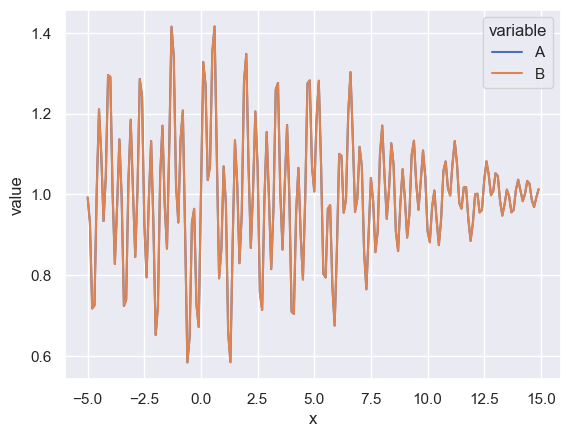

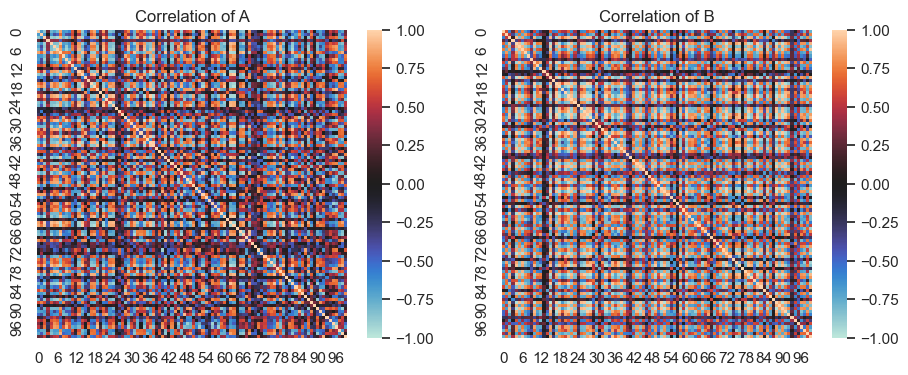

In [71]:
test_complex_pcorr(f3,arg100e,100,0,0,s=0.00)

## Generating actual

In [72]:
def gen_subject(func,func_args,num_f,b):
    w = func(np.arange(0,10,0.1),**func_args,b=b)
    df = gen_data_revised(w,100,num_features = num_f)
    return df

In [73]:
def gen_dist(func,func_args,num_f,num_each,b1,b2):
    df = pd.DataFrame(columns = ['gender', 'data', 'corr', 'pcorr', 'fcorr', 'fpcorr'])

    # gen m
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b1)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['M',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]

    # gen f
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b2)
        corr = subject.corr()
        pcorr = subject.pcorr()
        fcorr = apply_fisher(corr)
        fpcorr = apply_fisher(pcorr)

        df.loc[len(df.index)] = ['F',subject.to_numpy(),corr.to_numpy(),pcorr.to_numpy(),fcorr,fpcorr]
    
    return df

In [74]:
num_f = 100
num_each = 500
b1 = 0
b2 = 0
func = f3
func_args = arg100e

In [75]:
dist0 = gen_dist(func,func_args,num_f,num_each,0,0)
dist2 = gen_dist(func,func_args,num_f,num_each,0,2)
dist4 = gen_dist(func,func_args,num_f,num_each,0,4)
dist6 = gen_dist(func,func_args,num_f,num_each,0,6)
dist8 = gen_dist(func,func_args,num_f,num_each,0,8)
dist10 = gen_dist(func,func_args,num_f,num_each,0,10)

In [76]:
dist10.head()

gender                                               data  \
0      M  [[0.95454957164354, 1.569550065573715, 1.17141...   
1      M  [[1.0148902666771693, 1.3596474914465577, 1.39...   
2      M  [[1.102110099080337, 1.3807949062673437, 1.129...   
3      M  [[1.0815306320916152, 1.214667668097587, 1.369...   
4      M  [[1.1100565164703353, 1.1639284987818854, 1.35...   

                                                corr  \
0  [[1.0, -0.1557482549553622, -0.029968621817302...   
1  [[1.0, -0.1560169519056023, -0.009617602992436...   
2  [[1.0, 0.013304461890515233, 0.064181410962207...   
3  [[1.0, -0.041674703668821686, -0.0157806452377...   
4  [[1.0, -0.02724024489381702, -0.01823830980094...   

                                               pcorr  \
0  [[1.0, 0.42470614696659076, -0.142713208810457...   
1  [[1.0, 0.5691516680227314, 0.6083812296067297,...   
2  [[1.0, -0.0793186303152582, 0.5934948564563207...   
3  [[1.0, -0.3619253344296018, -0.025895345317989...   
4  [[1.0, 0.07306260819117566, -0.139243779981372...   

                                               fcorr  \
0  [[0.0, -0.15702626337338021, -0.02997759844420...   
1  [[0.0, -0.15730165210248517, -0.00961789954616...   
2  [[0.0, 0.013305246975759034, 0.064269755915232...   
3  [[0.0, -0.04169885545177653, -0.01578195537832...   
4  [[0.0, -0.027246985596682836, -0.0182403324437...   

                                              fpcorr  
0  [[0.0, 0.4534199498864046, -0.1436941066362828...  
1  [[0.0, 0.6462671416295673, 0.7063473313266043,...  
2  [[0.0, -0.07948560400983554, 0.683044161936267...  
3  [[0.0, -0.37909967874932415, -0.02590113585242...  
4  [[0.0, 0.07319303243943918, -0.140154320955059...

<AxesSubplot: >

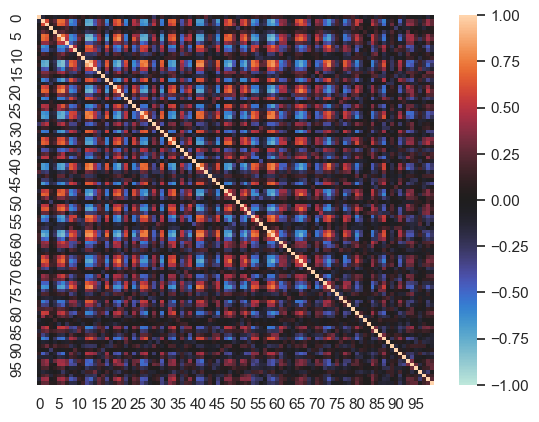

In [77]:
sns.heatmap(dist10.iloc[0]['corr'],**kwarg_dict)

<AxesSubplot: >

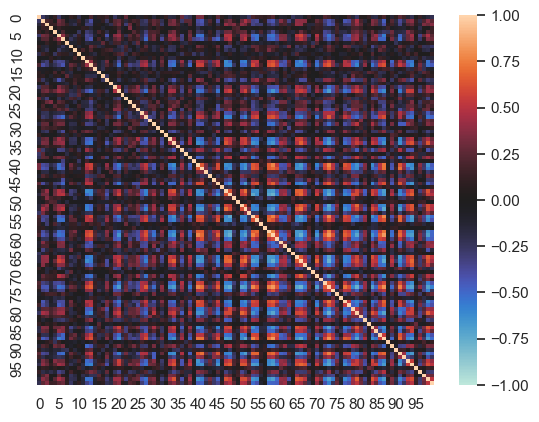

In [78]:
sns.heatmap(dist10.iloc[999]['corr'],**kwarg_dict)

In [113]:
import sys
np.set_printoptions(threshold=100**2)

In [86]:
# this takes multiple gigs. scrapped
dist0.to_csv('dist0.csv', index=False)
dist2.to_csv('dist2.csv', index=False)
dist4.to_csv('dist4.csv', index=False)
dist6.to_csv('dist6.csv', index=False)
dist8.to_csv('dist8.csv', index=False)
dist10.to_csv('dist10.csv', index=False)

KeyboardInterrupt: 

- combine both varying weights with multiple weight lists

In [80]:
test=pd.read_csv('dist10.csv')
test.head()

gender                                               data  \
0      M  [[0.95454957 1.56955007 1.17141224 ... 0.99536...   
1      M  [[1.01489027 1.35964749 1.3903445  ... 0.94333...   
2      M  [[1.1021101  1.38079491 1.12907449 ... 0.93498...   
3      M  [[1.08153063 1.21466767 1.36999933 ... 0.95612...   
4      M  [[1.11005652 1.1639285  1.35880597 ... 1.09910...   

                                                corr  \
0  [[ 1.00000000e+00 -1.55748255e-01 -2.99686218e...   
1  [[ 1.         -0.15601695 -0.0096176  ... -0.0...   
2  [[ 1.          0.01330446  0.06418141 ...  0.0...   
3  [[ 1.         -0.0416747  -0.01578065 ... -0.1...   
4  [[ 1.         -0.02724024 -0.01823831 ... -0.0...   

                                               pcorr  \
0  [[ 1.          0.42470615 -0.14271321 ... -0.0...   
1  [[ 1.          0.56915167  0.60838123 ...  0.2...   
2  [[ 1.         -0.07931863  0.59349486 ... -0.3...   
3  [[ 1.         -0.36192533 -0.02589535 ...  0.0...   
4  [[ 1.          0.07306261 -0.13924378 ...  0.0...   

                                               fcorr  \
0  [[ 0.         -0.15702626 -0.0299776  ... -0.0...   
1  [[ 0.         -0.15730165 -0.0096179  ... -0.0...   
2  [[ 0.          0.01330525  0.06426976 ...  0.0...   
3  [[ 0.         -0.04169886 -0.01578196 ... -0.1...   
4  [[ 0.         -0.02724699 -0.01824033 ... -0.0...   

                                              fpcorr  
0  [[ 0.          0.45341995 -0.14369411 ... -0.0...  
1  [[ 0.          0.64626714  0.70634733 ...  0.2...  
2  [[ 0.         -0.0794856   0.68304416 ... -0.4...  
3  [[ 0.         -0.37909968 -0.02590114 ...  0.0...  
4  [[ 0.          0.07319303 -0.14015432 ...  0.0...

In [119]:
def gen_dist2(func,func_args,num_f,num_each,b1,b2):
    df = pd.DataFrame(columns = ['gender','corr'])

    # gen m
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b1)
        corr = subject.corr()
#         fcorr = apply_fisher(corr)

        df.loc[len(df.index)] = ['M',corr.to_numpy().astype('float16')]

    # gen f
    for i in np.arange(num_each):
        subject = gen_subject(func,func_args,num_f,b2)
        corr = subject.corr()
#         fcorr = apply_fisher(corr)

        df.loc[len(df.index)] = ['F',corr.to_numpy().astype('float16')]
    
    return df

In [120]:
dist0 = gen_dist2(func,func_args,num_f,num_each,0,0)
dist2 = gen_dist2(func,func_args,num_f,num_each,0,2)
dist4 = gen_dist2(func,func_args,num_f,num_each,0,4)
dist6 = gen_dist2(func,func_args,num_f,num_each,0,6)
dist8 = gen_dist2(func,func_args,num_f,num_each,0,8)
dist10 = gen_dist2(func,func_args,num_f,num_each,0,10)

In [121]:
dist0.head()

gender                                               corr
0      M  [[1.0, 0.132, 0.08856, 0.1426, 0.003326, 0.069...
1      M  [[1.0, -0.0618, -0.1982, -0.1416, -0.1487, -0....
2      M  [[1.0, 0.1, 0.1035, -0.0702, -0.04868, 0.0971,...
3      M  [[1.0, 0.10205, 0.1239, 0.1283, -0.1533, -0.07...
4      M  [[1.0, -0.07104, -0.0392, -0.00445, 0.0306, -0...

## save gen methods as python file

In [122]:
import os

dist_file_paths = ['Data/sim/dist' + str(i) + '.csv' for i in range(0, 11, 2)]

ICAd = 100
np.set_printoptions(threshold = ICAd ** 2)

dist0.to_csv(dist_file_paths[0], index=False, compression = 'gzip')
dist2.to_csv(dist_file_paths[1], index=False, compression = 'gzip')
dist4.to_csv(dist_file_paths[2], index=False, compression = 'gzip')
dist6.to_csv(dist_file_paths[3], index=False, compression = 'gzip')
dist8.to_csv(dist_file_paths[4], index=False, compression = 'gzip')
dist10.to_csv(dist_file_paths[5], index=False, compression = 'gzip')

In [133]:
import pandas as pd
import numpy as np
import os

import gzip # Extract gz file
from ast import literal_eval # Gets network matrix array from csv 
import re

convert = lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))

with gzip.open('Data/sim/dist0.csv') as filepath:
    dist0_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})
with gzip.open('Data/sim/dist2.csv') as filepath:
    dist2_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})
with gzip.open('Data/sim/dist4.csv') as filepath:
    dist4_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})
with gzip.open('Data/sim/dist6.csv') as filepath:
    dist6_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})
with gzip.open('Data/sim/dist8.csv') as filepath:
    dist8_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})
with gzip.open('Data/sim/dist10.csv') as filepath:
    dist10_unc = pd.read_csv(filepath, 
            converters = {'corr': convert})

In [128]:
dist0_unc.head()

gender                                               corr
0      M  [[1.0, 0.13196, 0.088562, 0.14258, 0.0033264, ...
1      M  [[1.0, -0.061798, -0.19824, -0.1416, -0.14868,...
2      M  [[1.0, 0.099976, 0.10352, -0.07019, -0.048676,...
3      M  [[1.0, 0.10205, 0.1239, 0.1283, -0.15332, -0.0...
4      M  [[1.0, -0.071045, -0.039215, -0.0044518, 0.030...

<AxesSubplot: >

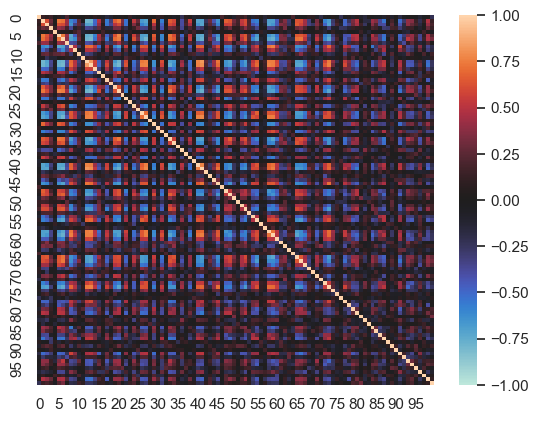

In [132]:
sns.heatmap(dist0_unc['corr'][0],**kwarg_dict)

In [134]:
dist10_unc.head()

gender                                               corr
0      M  [[1.0, -0.031189, -0.088562, -0.016739, 0.0750...
1      M  [[1.0, -0.033905, -0.013313, -0.10333, -0.0859...
2      M  [[1.0, 0.10016, 0.13965, 0.064941, 0.097229, 0...
3      M  [[1.0, 0.19177, 0.040375, 0.26465, -0.0073166,...
4      M  [[1.0, -0.010994, 0.067322, -0.01062, -0.01760...

## lower separability

Generate data

In [151]:
dist00 = gen_dist2(func,func_args,num_f,num_each,0,0)
dist01 = gen_dist2(func,func_args,num_f,num_each,0,0.1)
dist02 = gen_dist2(func,func_args,num_f,num_each,0,0.2)
dist03 = gen_dist2(func,func_args,num_f,num_each,0,0.3)
dist04 = gen_dist2(func,func_args,num_f,num_each,0,0.4)
dist05 = gen_dist2(func,func_args,num_f,num_each,0,0.5)

In [154]:
dist06 = gen_dist2(func,func_args,num_f,num_each,0,0.6)
dist07 = gen_dist2(func,func_args,num_f,num_each,0,0.7)
dist08 = gen_dist2(func,func_args,num_f,num_each,0,0.8)
dist09 = gen_dist2(func,func_args,num_f,num_each,0,0.9)
dist10 = gen_dist2(func,func_args,num_f,num_each,0,1.0)

Save data

In [182]:
import os
ICAd = 100
np.set_printoptions(threshold = ICAd ** 2)

for i in np.arange(0,1.1,0.1):
    i = np.round(i,1)
    filepath = 'Data/sim/dist' + str(i).replace('.','') + '.csv'
    
    df = gen_dist2(func,func_args,num_f,num_each,0,i)
    df = df.reset_index().rename(columns={'index':'subject_id'}).set_index('subject_id')
    df.to_csv(filepath, index=True, compression = 'gzip')
    print('Finished ' + filepath)

Finished Data/sim/dist00.csv
Finished Data/sim/dist01.csv
Finished Data/sim/dist02.csv
Finished Data/sim/dist03.csv
Finished Data/sim/dist04.csv
Finished Data/sim/dist05.csv
Finished Data/sim/dist06.csv
Finished Data/sim/dist07.csv
Finished Data/sim/dist08.csv
Finished Data/sim/dist09.csv
Finished Data/sim/dist10.csv


Retrieve data

In [183]:
import pandas as pd
import numpy as np
import os

import gzip # Extract gz file
from ast import literal_eval # Gets network matrix array from csv 
import re

convert = lambda x : np.array(literal_eval(re.sub('(?<!\[)\s+|[\\n]', ', ', x)))

with gzip.open('Data/sim/dist00.csv') as filepath:
    dist0_unc = pd.read_csv(filepath, index_col = 'subject_id', converters = {'corr': convert})

Python file

In [192]:
import retrieve_sim

In [194]:
test = retrieve_sim.uncompress('Data/sim/dist00.csv')

In [196]:
test.head()

gender                                               corr
subject_id                                                          
0               M  [[1.0, -0.11011, 0.022797, 0.081909, -0.18457,...
1               M  [[1.0, 0.18799, 0.13684, 0.069214, 0.016022, 0...
2               M  [[1.0, 0.0076447, -0.027496, -0.038635, 0.1068...
3               M  [[1.0, -0.031952, -0.19287, -0.071838, 0.11102...
4               M  [[1.0, -0.0023594, 0.086792, -0.0049171, -0.02...

## Testing KNN

In [197]:
import os

# Data science and vis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [220]:
# from KKN Simulated Data.ipynb
def knn10(data,n_neighbors):
    X = data['corr'].apply(lambda x : x.flatten()).to_list()
    y = data['gender'].to_list()
    
    # Generate Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 6)
    
    # Knn classifier
    knn10 = KNeighborsClassifier(n_neighbors)
    
    knn10.fit(X_train, y_train)
    y_pred_2 = knn10.predict(X_test)
    
    score = accuracy_score(y_test, y_pred_2)*100
    print("   Accuracy with k="+str(n_neighbors) + ': '+ str(score))
    return score

In [203]:
distributions = []
for i in np.arange(0,1.1,0.1):
    i = np.round(i,1)
    filepath = 'Data/sim/dist' + str(i).replace('.','') + '.csv'
    distributions += [retrieve_sim.uncompress(filepath)]
    print("Finished loading: " + filepath)

Finished loading: Data/sim/dist00.csv
Finished loading: Data/sim/dist01.csv
Finished loading: Data/sim/dist02.csv
Finished loading: Data/sim/dist03.csv
Finished loading: Data/sim/dist04.csv
Finished loading: Data/sim/dist05.csv
Finished loading: Data/sim/dist06.csv
Finished loading: Data/sim/dist07.csv
Finished loading: Data/sim/dist08.csv
Finished loading: Data/sim/dist09.csv
Finished loading: Data/sim/dist10.csv


In [237]:
for i in distributions:
    knn10(i,10)

   Accuracy with k=10: 48.4
   Accuracy with k=10: 45.6
   Accuracy with k=10: 56.8
   Accuracy with k=10: 60.4
   Accuracy with k=10: 70.39999999999999
   Accuracy with k=10: 70.8
   Accuracy with k=10: 81.2
   Accuracy with k=10: 79.60000000000001
   Accuracy with k=10: 81.6
   Accuracy with k=10: 86.4
   Accuracy with k=10: 92.0


In [234]:
lst = []
for i in np.arange(1,15,1):
    print("nearest neighbours: " + str(i))
    for j in np.arange(len(distributions)):
        score = knn10(distributions[j],i)
        lst += [[i,score,j]]

nearest neighbours: 1
   Accuracy with k=1: 50.4
   Accuracy with k=1: 41.199999999999996
   Accuracy with k=1: 51.2
   Accuracy with k=1: 54.400000000000006
   Accuracy with k=1: 64.8
   Accuracy with k=1: 62.8
   Accuracy with k=1: 71.2
   Accuracy with k=1: 77.60000000000001
   Accuracy with k=1: 80.4
   Accuracy with k=1: 84.39999999999999
   Accuracy with k=1: 88.0
nearest neighbours: 2
   Accuracy with k=2: 48.8
   Accuracy with k=2: 46.0
   Accuracy with k=2: 53.6
   Accuracy with k=2: 53.2
   Accuracy with k=2: 62.0
   Accuracy with k=2: 60.4
   Accuracy with k=2: 68.0
   Accuracy with k=2: 72.0
   Accuracy with k=2: 70.39999999999999
   Accuracy with k=2: 76.8
   Accuracy with k=2: 84.0
nearest neighbours: 3
   Accuracy with k=3: 54.400000000000006
   Accuracy with k=3: 48.0
   Accuracy with k=3: 56.00000000000001
   Accuracy with k=3: 64.8
   Accuracy with k=3: 67.2
   Accuracy with k=3: 67.2
   Accuracy with k=3: 74.8
   Accuracy with k=3: 80.0
   Accuracy with k=3: 84.8
   

[Text(0.5, 0, 'n_neighbours'),
 Text(0, 0.5, 'Accuracy Score'),
 Text(0.5, 1.0, 'KNN on Simulated Data')]

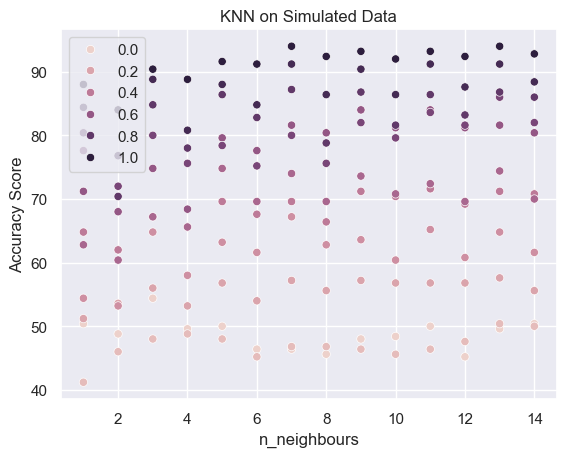

In [243]:
result = np.array(lst).T
ax = sns.scatterplot(x=result[0],y=result[1],hue=result[2]/10)
ax.set(xlabel='n_neighbours', ylabel='Accuracy Score', title='KNN on Simulated Data')